# Loadings and Initialisations

In [ ]:
import numpy as np
import pandas as pd

import sys
import os

# Absolute path to the utils directory
utils_path = os.path.abspath(r".\utils")

# Add it to sys.path
if utils_path not in sys.path:
    sys.path.append(utils_path)

In [2]:
# Necessary to not clog the output for pdf
import warnings
from scipy.sparse import SparseEfficiencyWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

In [ ]:
# Loading the views

# Load all sheets from the Excel file
xls_path = r"..\Datasets\Final Datasets\subnationalindicatorsdataset.xlsx"
all_views = pd.read_excel(xls_path, sheet_name=None)

# Convert sheet names to lowercase keys and assign to variables
views = {}
for sheet_name, df in all_views.items():
    key = sheet_name.lower()
    views[key] = df
    globals()[f"{key}_df"] = df

# Remove the 'spatial' view if it exists
# views.pop("spatial", None)

print(views)

{'economic':      Area Code         Area Level                  Area  \
0    E06000001  Unitary Authority            Hartlepool   
1    E06000002  Unitary Authority         Middlesbrough   
2    E06000003  Unitary Authority  Redcar and Cleveland   
3    E06000004  Unitary Authority      Stockton-on-Tees   
4    E06000005  Unitary Authority            Darlington   
..         ...                ...                   ...   
304  E09000029     London Borough                Sutton   
305  E09000030     London Borough         Tower Hamlets   
306  E09000031     London Borough        Waltham Forest   
307  E09000032     London Borough            Wandsworth   
308  E09000033     London Borough           Westminster   

     Gross Value Added (GVA) per hour worked (£) Gross median weekly pay (£)  \
0                                          31.85                       487.4   
1                                          30.96                       420.8   
2                                     

In [4]:
# Constants
META_COLS = [
    "Local_Authority_Name", "Local Authority Name", 
    "Area", "Area Level", "Area Code", 
    "Local_Authority_Code"
]

# Exclusions for each view based on ONS guidelines
ONS_EXCLUSIONS = {
    'economic': ['E06000053', 'E09000001'],
    'connectivity': ['E06000053', 'E06000057', 'E06000058', 'E06000059',
                     'E06000060', 'E06000061', 'E06000062', 'E08000037'],
    'educational_attainment': ['E06000017', 'E06000053', 'E06000060',
                                'E06000061', 'E06000062', 'E09000001'],
    'skills': ['E06000053', 'E07000166', 'E09000001'],
    'health': ['E06000022', 'E06000049', 'E06000050', 'E06000053', 'E06000060',
               'E06000061', 'E06000062', 'E07000234', 'E07000236', 'E07000237',
               'E07000238', 'E07000239', 'E08000001', 'E08000002', 'E09000001',
               'E09000010', 'E09000025', 'E09000032'],
    'wellbeing': ['E06000053', 'E09000001']
} 

# Known optimal number of clusters per view (ONS-determined)
ONS_K_VALUES = {
    'economic': 4,
    'connectivity': 4,
    'educational_attainment': 8,
    'skills': 4,
    'health': 4,
    'wellbeing': 4
}

# Overview

| Strategy         | Distance-based                                                                              | Factorization-based                       | Autoencoder/Deep-based                      |
| ---------------- | ------------------------------------------------------------------------------------------- | ----------------------------------------- | ------------------------------------------- |
| **Early**        | Masked Cosine                                                                  | Masked Tri-Factorization                | Masked Autoencoder                        |
| **Intermediate** | Multi-view Similarity Fusion (MVSF) | Per-view NMF or NMTF → concat $G^{(v)}$ | Multi-branch Encoder (shared latent)      |
| **Late**         | Cluster Co-association (ensemble)                                                         | Collective Matrix Factorization         | Ensemble of per-view AEs + cluster voting |


## Similarity-based Methods

### Early - Masked Cosine Similarity (MCS)

In [5]:
from similarity_based_methods import run_early_mcs_pca_kmeans

# Run the early integration masked cosine similarity PCA + KMeans
MCS_out = run_early_mcs_pca_kmeans(
    views=views,
    k_range=range(4, 16),
    n_pca_range=range(2, 6),
    n_init=100,               
    normalize_rows=True,
    zero_diagonal=True,
    verbose=True
)

# Unpack results
MCS_S = MCS_out["S"]
area_codes = MCS_out["area_codes"]
MCS_labels = MCS_out["labels"]
MCS_embedding = MCS_out["embedding"]
MCS_sil = MCS_out["silhouette"]
MCS_best_params = MCS_out["best_params"]
MCS_assign_df = MCS_out["assignments_df"]
MCS_grid_results = MCS_out["grid_results"]

print("Best params (n_pca, k):", MCS_best_params)
print("Best silhouette:", MCS_sil)
display(MCS_assign_df.head())
display(MCS_grid_results.head())

  File "c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


n=309, PCA=2, K=4 → Silhouette: 0.4954
n=309, PCA=2, K=5 → Silhouette: 0.4442
n=309, PCA=2, K=6 → Silhouette: 0.4332
n=309, PCA=2, K=7 → Silhouette: 0.4290
n=309, PCA=2, K=8 → Silhouette: 0.4182
n=309, PCA=2, K=9 → Silhouette: 0.3842
n=309, PCA=2, K=10 → Silhouette: 0.3790
n=309, PCA=2, K=11 → Silhouette: 0.3922
n=309, PCA=2, K=12 → Silhouette: 0.4064
n=309, PCA=2, K=13 → Silhouette: 0.3971
n=309, PCA=2, K=14 → Silhouette: 0.4014
n=309, PCA=2, K=15 → Silhouette: 0.4095
n=309, PCA=3, K=4 → Silhouette: 0.4731
n=309, PCA=3, K=5 → Silhouette: 0.4225
n=309, PCA=3, K=6 → Silhouette: 0.4191
n=309, PCA=3, K=7 → Silhouette: 0.4084
n=309, PCA=3, K=8 → Silhouette: 0.3867
n=309, PCA=3, K=9 → Silhouette: 0.3490
n=309, PCA=3, K=10 → Silhouette: 0.3561
n=309, PCA=3, K=11 → Silhouette: 0.3531
n=309, PCA=3, K=12 → Silhouette: 0.3582
n=309, PCA=3, K=13 → Silhouette: 0.3557
n=309, PCA=3, K=14 → Silhouette: 0.3538
n=309, PCA=3, K=15 → Silhouette: 0.3528
n=309, PCA=4, K=4 → Silhouette: 0.4724
n=309, PCA=4,

Local_Authority_Code  Cluster
0            E06000001        3
1            E06000002        3
2            E06000003        3
3            E06000004        3
4            E06000005        3

PCA_n_components  K  Silhouette
0                 2  4    0.495401
1                 2  5    0.444208
2                 2  6    0.433155
3                 2  7    0.429040
4                 2  8    0.418201

### Intermediate - Multi-View Similarity Fusion (MVSF)

In [6]:
from similarity_based_methods import run_mvsf_pca_kmeans

MVSF_out = run_mvsf_pca_kmeans(
    views=views,
    k_range=range(4, 16),
    n_pca_range=range(2, 6),
    n_init=100,
    normalize_rows=True,
    zero_diagonal=True,
    verbose=True
)

# Unpack
MVSF_S_fused = MVSF_out["S_fused"]
area_codes = MVSF_out["area_codes"]
MVSF_similarity_matrices = MVSF_out["similarity_matrices"]
MVSF_view_names = MVSF_out["view_names"]
MVSF_labels = MVSF_out["labels"]
MVSF_best_params = MVSF_out["best_params"]
MVSF_per_view_contributions = MVSF_out["per_view_contributions_per_la"]
MVSF_embedding = MVSF_out["embedding"]

# Handy assignments and grid search history:
MVSF_assignments_df = MVSF_out["assignments_df"] # LA code → cluster
MVSF_grid_results = MVSF_out["grid_results"] # (PCA_n_components, K, Silhouette)
display(MVSF_assignments_df.head())
display(MVSF_grid_results.head())

n=309, PCA=2, K=4 → Silhouette: 0.7587
n=309, PCA=2, K=5 → Silhouette: 0.7546
n=309, PCA=2, K=6 → Silhouette: 0.6611
n=309, PCA=2, K=7 → Silhouette: 0.6343
n=309, PCA=2, K=8 → Silhouette: 0.5884
n=309, PCA=2, K=9 → Silhouette: 0.5817
n=309, PCA=2, K=10 → Silhouette: 0.5858
n=309, PCA=2, K=11 → Silhouette: 0.5788
n=309, PCA=2, K=12 → Silhouette: 0.5704
n=309, PCA=2, K=13 → Silhouette: 0.5785
n=309, PCA=2, K=14 → Silhouette: 0.5408
n=309, PCA=2, K=15 → Silhouette: 0.5276
n=309, PCA=3, K=4 → Silhouette: 0.7366
n=309, PCA=3, K=5 → Silhouette: 0.6439
n=309, PCA=3, K=6 → Silhouette: 0.6058
n=309, PCA=3, K=7 → Silhouette: 0.6122
n=309, PCA=3, K=8 → Silhouette: 0.5913
n=309, PCA=3, K=9 → Silhouette: 0.5743
n=309, PCA=3, K=10 → Silhouette: 0.5834
n=309, PCA=3, K=11 → Silhouette: 0.5895
n=309, PCA=3, K=12 → Silhouette: 0.5823
n=309, PCA=3, K=13 → Silhouette: 0.5755
n=309, PCA=3, K=14 → Silhouette: 0.5814
n=309, PCA=3, K=15 → Silhouette: 0.5455
n=309, PCA=4, K=4 → Silhouette: 0.6852
n=309, PCA=4,

Local_Authority_Code  Cluster
0            E06000001        1
1            E06000002        1
2            E06000003        1
3            E06000004        1
4            E06000005        1

PCA_n_components  K  Silhouette
0                 2  4    0.758736
1                 2  5    0.754605
2                 2  6    0.661098
3                 2  7    0.634279
4                 2  8    0.588419

### Late - Co-association Similarity Ensemble (CSE)

In [7]:
from similarity_based_methods import run_late_coassoc_pca_kmeans

CSE_out = run_late_coassoc_pca_kmeans(
    views=views,
    ons_k_values=ONS_K_VALUES,
    k_range=range(4, 16),
    n_pca_range=range(2, 6),
    n_init=100,
    verbose=True
)

# Unpack for reporting/plots
CSE_S= CSE_out["S_coassoc"]
area_codes= CSE_out["area_codes"]
CSE_labels = CSE_out["labels"]
CSE_embedding = CSE_out["embedding"]
CSE_assign_df = CSE_out["assignments_df"]
CSE_grid_res = CSE_out["grid_results"]
CSE_clusterings = CSE_out["clusterings"]  # per-view labelings if you want to inspect them

print("Best (n_pca, k):", CSE_out["best_params"])
print("Best silhouette:", CSE_out["silhouette"])
display(CSE_assign_df.head())
display(CSE_grid_res.head())

[spatial] skipped: no k value defined in ons_k_values
n=309, PCA=2, K=4 → Silhouette: 0.4877
n=309, PCA=2, K=5 → Silhouette: 0.5207
n=309, PCA=2, K=6 → Silhouette: 0.5085
n=309, PCA=2, K=7 → Silhouette: 0.5129
n=309, PCA=2, K=8 → Silhouette: 0.5252
n=309, PCA=2, K=9 → Silhouette: 0.5174
n=309, PCA=2, K=10 → Silhouette: 0.4897
n=309, PCA=2, K=11 → Silhouette: 0.4960
n=309, PCA=2, K=12 → Silhouette: 0.5027
n=309, PCA=2, K=13 → Silhouette: 0.5088
n=309, PCA=2, K=14 → Silhouette: 0.5049
n=309, PCA=2, K=15 → Silhouette: 0.4747
n=309, PCA=3, K=4 → Silhouette: 0.4022
n=309, PCA=3, K=5 → Silhouette: 0.3857
n=309, PCA=3, K=6 → Silhouette: 0.4023
n=309, PCA=3, K=7 → Silhouette: 0.4441
n=309, PCA=3, K=8 → Silhouette: 0.4952
n=309, PCA=3, K=9 → Silhouette: 0.5152
n=309, PCA=3, K=10 → Silhouette: 0.5483
n=309, PCA=3, K=11 → Silhouette: 0.5747
n=309, PCA=3, K=12 → Silhouette: 0.5808
n=309, PCA=3, K=13 → Silhouette: 0.5915
n=309, PCA=3, K=14 → Silhouette: 0.6029
n=309, PCA=3, K=15 → Silhouette: 0.590

Local_Authority_Code  Cluster
0            E06000001       12
1            E06000002        6
2            E06000003        6
3            E06000004        6
4            E06000005        9

PCA_n_components  K  Silhouette
0                 2  4    0.487696
1                 2  5    0.520656
2                 2  6    0.508477
3                 2  7    0.512922
4                 2  8    0.525202

## Factorisation-based Methods

### Early - Masked Non-Negative Matrix Factorisation (MNMF)

In [8]:
from matrix_factorisation_based_methods import run_early_mmf_pca_kmeans

MNMF_out = run_early_mmf_pca_kmeans(
    views=views,
    rank_range=range(2, 6),
    n_pca_range=range(2, 6),
    k_range=range(4, 16),
    n_init=100,
    verbose=True
)

# Unpack for reporting/plots
area_codes= MNMF_out["area_codes"]
MNMF_labels = MNMF_out["labels"]
MNMF_embedding = MNMF_out["embedding"]
MNMF_assign_df = MNMF_out["assignments_df"]
MNMF_grid_res = MNMF_out["grid_results"]

display(MNMF_assign_df.head())
display(MNMF_grid_res.head())

n=309, Rank=2, PCA=2, K=4 → Silhouette=0.6237
n=309, Rank=2, PCA=2, K=5 → Silhouette=0.6352
n=309, Rank=2, PCA=2, K=6 → Silhouette=0.5916
n=309, Rank=2, PCA=2, K=7 → Silhouette=0.5971
n=309, Rank=2, PCA=2, K=8 → Silhouette=0.6041
n=309, Rank=2, PCA=2, K=9 → Silhouette=0.5575
n=309, Rank=2, PCA=2, K=10 → Silhouette=0.5560
n=309, Rank=2, PCA=2, K=11 → Silhouette=0.5418
n=309, Rank=2, PCA=2, K=12 → Silhouette=0.5375
n=309, Rank=2, PCA=2, K=13 → Silhouette=0.5411
n=309, Rank=2, PCA=2, K=14 → Silhouette=0.5433
n=309, Rank=2, PCA=2, K=15 → Silhouette=0.5456
Skipping Rank=2, PCA=3 (Z dim=2)
Skipping Rank=2, PCA=4 (Z dim=2)
Skipping Rank=2, PCA=5 (Z dim=2)
n=309, Rank=3, PCA=2, K=4 → Silhouette=0.9870
n=309, Rank=3, PCA=2, K=5 → Silhouette=0.9823
n=309, Rank=3, PCA=2, K=6 → Silhouette=0.9800
n=309, Rank=3, PCA=2, K=7 → Silhouette=0.9797
n=309, Rank=3, PCA=2, K=8 → Silhouette=0.9769
n=309, Rank=3, PCA=2, K=9 → Silhouette=0.9735
n=309, Rank=3, PCA=2, K=10 → Silhouette=0.9709
n=309, Rank=3, PCA=2

Local_Authority_Code  Cluster
0            E06000001        2
1            E06000002        0
2            E06000003        0
3            E06000004        0
4            E06000005        0

PCA_n_components  K  Silhouette  Rank
0                 2  4    0.993513     5
1                 2  5    0.993513     5
2                 2  6    0.980047     3
3                 2  7    0.979720     3
4                 2  8    0.976880     3

### Intermediate - Per-View NMF + concatenated G matrices (PVNMF)

In [9]:
from matrix_factorisation_based_methods import run_intermediate_pvnmf_pca_kmeans

PVNMF_out = run_intermediate_pvnmf_pca_kmeans(
    views=views,
    rank_range=range(2, 6),
    n_pca_range=range(2, 6),
    k_range=range(4, 16),
    n_init=100,
    verbose=True
)

# Unpack for reporting/plots
area_codes= PVNMF_out["area_codes"]
PVNMF_labels  = PVNMF_out["labels"]
PVNMF_embedding = PVNMF_out["embedding"]
PVNMF_assign_df= PVNMF_out["assignments_df"]
PVNMF_grid_res = PVNMF_out["grid_results"]

display(PVNMF_assign_df.head())
display(PVNMF_grid_res.head())

[spatial] skipped: contains negatives (NMF requires nonnegative).
n=309, PVNMF Rank=2, PCA=2, K=4 → Silhouette=0.6783
n=309, PVNMF Rank=2, PCA=2, K=5 → Silhouette=0.6744
n=309, PVNMF Rank=2, PCA=2, K=6 → Silhouette=0.6475
n=309, PVNMF Rank=2, PCA=2, K=7 → Silhouette=0.6521
n=309, PVNMF Rank=2, PCA=2, K=8 → Silhouette=0.6388
n=309, PVNMF Rank=2, PCA=2, K=9 → Silhouette=0.5730
n=309, PVNMF Rank=2, PCA=2, K=10 → Silhouette=0.5527
n=309, PVNMF Rank=2, PCA=2, K=11 → Silhouette=0.5285
n=309, PVNMF Rank=2, PCA=2, K=12 → Silhouette=0.5239
n=309, PVNMF Rank=2, PCA=2, K=13 → Silhouette=0.5265
n=309, PVNMF Rank=2, PCA=2, K=14 → Silhouette=0.5077
n=309, PVNMF Rank=2, PCA=2, K=15 → Silhouette=0.5175
n=309, PVNMF Rank=2, PCA=3, K=4 → Silhouette=0.6318
n=309, PVNMF Rank=2, PCA=3, K=5 → Silhouette=0.5646
n=309, PVNMF Rank=2, PCA=3, K=6 → Silhouette=0.5720
n=309, PVNMF Rank=2, PCA=3, K=7 → Silhouette=0.5587
n=309, PVNMF Rank=2, PCA=3, K=8 → Silhouette=0.5574
n=309, PVNMF Rank=2, PCA=3, K=9 → Silhouette

Local_Authority_Code  Cluster
0            E06000001        1
1            E06000002        3
2            E06000003        3
3            E06000004        3
4            E06000005        3

PCA_n_components  K  Silhouette  Rank
0                 2  4    0.678255     2
1                 2  5    0.674442     2
2                 2  6    0.647468     2
3                 2  7    0.652068     2
4                 2  8    0.638758     2

### Late - Co-association Factorization Ensemble (CFE)

In [10]:
from matrix_factorisation_based_methods import run_late_nmf_coassoc_pca_kmeans

CFE_out = run_late_nmf_coassoc_pca_kmeans(
    views=views,
    rank_range=range(2, 6),
    n_pca_range=range(2, 6),
    k_range=range(4, 16),
    n_init=100,
    verbose=True
)

# Unpack for reporting/plots
area_codes= CFE_out["area_codes"]
CFE_labels = CFE_out["labels"]
CFE_embedding= CFE_out["embedding"]
CFE_assign_df = CFE_out["assignments_df"]
CFE_grid_res = CFE_out["grid_results"]

display(CFE_assign_df.head())
display(CFE_grid_res.head())

[spatial] skipped: negatives present (NMF requires nonnegatives).
n=309, LATE-NMF Rank=2, PCA=2, K=4 → Silhouette=0.6155
n=309, LATE-NMF Rank=2, PCA=2, K=5 → Silhouette=0.6767
n=309, LATE-NMF Rank=2, PCA=2, K=6 → Silhouette=0.7066
n=309, LATE-NMF Rank=2, PCA=2, K=7 → Silhouette=0.7369
n=309, LATE-NMF Rank=2, PCA=2, K=8 → Silhouette=0.7484
n=309, LATE-NMF Rank=2, PCA=2, K=9 → Silhouette=0.7535
n=309, LATE-NMF Rank=2, PCA=2, K=10 → Silhouette=0.7683
n=309, LATE-NMF Rank=2, PCA=2, K=11 → Silhouette=0.7621
n=309, LATE-NMF Rank=2, PCA=2, K=12 → Silhouette=0.7746
n=309, LATE-NMF Rank=2, PCA=2, K=13 → Silhouette=0.7132
n=309, LATE-NMF Rank=2, PCA=2, K=14 → Silhouette=0.7201
n=309, LATE-NMF Rank=2, PCA=2, K=15 → Silhouette=0.7320
n=309, LATE-NMF Rank=2, PCA=3, K=4 → Silhouette=0.5475
n=309, LATE-NMF Rank=2, PCA=3, K=5 → Silhouette=0.6249
n=309, LATE-NMF Rank=2, PCA=3, K=6 → Silhouette=0.7006
n=309, LATE-NMF Rank=2, PCA=3, K=7 → Silhouette=0.7636
n=309, LATE-NMF Rank=2, PCA=3, K=8 → Silhouette=

Local_Authority_Code  Cluster
0            E06000001        2
1            E06000002        4
2            E06000003        4
3            E06000004        2
4            E06000005        2

PCA_n_components  K  Silhouette  Rank
0                 2  4    0.615530     2
1                 2  5    0.676676     2
2                 2  6    0.706611     2
3                 2  7    0.736878     2
4                 2  8    0.748370     2

## Autoencoder-based Methods

### Early - Masked Autoencoder (MA)

In [11]:
from autoencoder_based_methods import run_early_masked_ae_pca_kmeans

MA_out = run_early_masked_ae_pca_kmeans(
    views=views,
    latent_dim_range=[5,8,10],
    n_pca_range=range(2, 6),
    k_range=range(4, 16),
    hidden_dim = 128,
    epochs = 100,
    lr = 1e-3,
    n_init=100,
    random_state = 19042022,
    verbose=True
)

# Unpack for reporting/plots
area_codes= MA_out["area_codes"]
MA_labels = MA_out["labels"]
MA_embedding = MA_out["embedding"]
MA_assign_df= MA_out["assignments_df"]
MA_grid_res = MA_out["grid_results"]

display(MA_assign_df.head())
display(MA_grid_res.head())

[EARLY-AE] n=309, Latent=5, PCA=2, K=4 → Sil=0.4466
[EARLY-AE] n=309, Latent=5, PCA=2, K=5 → Sil=0.4262
[EARLY-AE] n=309, Latent=5, PCA=2, K=6 → Sil=0.4350
[EARLY-AE] n=309, Latent=5, PCA=2, K=7 → Sil=0.4584
[EARLY-AE] n=309, Latent=5, PCA=2, K=8 → Sil=0.4531
[EARLY-AE] n=309, Latent=5, PCA=2, K=9 → Sil=0.3985
[EARLY-AE] n=309, Latent=5, PCA=2, K=10 → Sil=0.4010
[EARLY-AE] n=309, Latent=5, PCA=2, K=11 → Sil=0.4092
[EARLY-AE] n=309, Latent=5, PCA=2, K=12 → Sil=0.4108
[EARLY-AE] n=309, Latent=5, PCA=2, K=13 → Sil=0.4131
[EARLY-AE] n=309, Latent=5, PCA=2, K=14 → Sil=0.4096
[EARLY-AE] n=309, Latent=5, PCA=2, K=15 → Sil=0.3921
[EARLY-AE] n=309, Latent=5, PCA=3, K=4 → Sil=0.3766
[EARLY-AE] n=309, Latent=5, PCA=3, K=5 → Sil=0.3375
[EARLY-AE] n=309, Latent=5, PCA=3, K=6 → Sil=0.3612
[EARLY-AE] n=309, Latent=5, PCA=3, K=7 → Sil=0.3682
[EARLY-AE] n=309, Latent=5, PCA=3, K=8 → Sil=0.3764
[EARLY-AE] n=309, Latent=5, PCA=3, K=9 → Sil=0.3717
[EARLY-AE] n=309, Latent=5, PCA=3, K=10 → Sil=0.3192
[EARL

Local_Authority_Code  Cluster
0            E06000001        3
1            E06000002        3
2            E06000003        3
3            E06000004        3
4            E06000005        3

PCA_n_components  K  Silhouette  Latent
0                 2  4    0.618818       8
1                 2  5    0.426711       8
2                 2  6    0.435045       5
3                 2  7    0.458415       5
4                 2  8    0.461396      10

### Intermediate - Multi-Branch Autoencoder with Shared Bottleneck (MBASB)

In [12]:
from autoencoder_based_methods import run_intermediate_multibranch_ae_pca_kmeans

MBASB_out = run_intermediate_multibranch_ae_pca_kmeans(
    views,
    latent_dim_range=[5,8,10],
    n_pca_range=range(2, 6), k_range=range(4, 16),
    epochs=100,
    n_init=100,
    verbose=True)

area_codes= MBASB_out["area_codes"]
MBASB_labels = MBASB_out["labels"]
MBASB_embedding = MBASB_out["embedding"]
MBASB_assign_df = MBASB_out["assignments_df"]
MBASB_grid_res = MBASB_out["grid_results"]

display(MBASB_assign_df.head())
display(MBASB_grid_res.head())

[MBAE] n=309, Latent=5, PCA=2, K=4 → Sil=0.3639
[MBAE] n=309, Latent=5, PCA=2, K=5 → Sil=0.4012
[MBAE] n=309, Latent=5, PCA=2, K=6 → Sil=0.4356
[MBAE] n=309, Latent=5, PCA=2, K=7 → Sil=0.4412
[MBAE] n=309, Latent=5, PCA=2, K=8 → Sil=0.4091
[MBAE] n=309, Latent=5, PCA=2, K=9 → Sil=0.3881
[MBAE] n=309, Latent=5, PCA=2, K=10 → Sil=0.3758
[MBAE] n=309, Latent=5, PCA=2, K=11 → Sil=0.3821
[MBAE] n=309, Latent=5, PCA=2, K=12 → Sil=0.3832
[MBAE] n=309, Latent=5, PCA=2, K=13 → Sil=0.3709
[MBAE] n=309, Latent=5, PCA=2, K=14 → Sil=0.3698
[MBAE] n=309, Latent=5, PCA=2, K=15 → Sil=0.3674
[MBAE] n=309, Latent=5, PCA=3, K=4 → Sil=0.3372
[MBAE] n=309, Latent=5, PCA=3, K=5 → Sil=0.3749
[MBAE] n=309, Latent=5, PCA=3, K=6 → Sil=0.4036
[MBAE] n=309, Latent=5, PCA=3, K=7 → Sil=0.4077
[MBAE] n=309, Latent=5, PCA=3, K=8 → Sil=0.3549
[MBAE] n=309, Latent=5, PCA=3, K=9 → Sil=0.3576
[MBAE] n=309, Latent=5, PCA=3, K=10 → Sil=0.3493
[MBAE] n=309, Latent=5, PCA=3, K=11 → Sil=0.3330
[MBAE] n=309, Latent=5, PCA=3, K

Local_Authority_Code  Cluster
0            E06000001        0
1            E06000002        0
2            E06000003        0
3            E06000004        0
4            E06000005        0

PCA_n_components  K  Silhouette  Latent
0                 2  4    0.480954      10
1                 2  5    0.494936       8
2                 2  6    0.435580       5
3                 2  7    0.441163       5
4                 2  8    0.409129       5

### Late - Autoencoder Ensemble with Consensus Clustering (AECC)

In [13]:
from autoencoder_based_methods import run_late_ae_coassoc_pca_kmeans

AECC_out = run_late_ae_coassoc_pca_kmeans(
    views, 
    latent_dim_range=[5,8,10],
    n_pca_range=range(2, 6),
    k_range=range(4, 16),
    epochs=100, 
    n_init=100, 
    verbose=True)

AECC_S = AECC_out["S_coassoc"]
area_codes= AECC_out["area_codes"]
AECC_labels = AECC_out["labels"]
AECC_embedding = AECC_out["embedding"]
AECC_assign_df = AECC_out["assignments_df"]
AECC_grid_res = AECC_out["grid_results"]
AECC_clusterings = AECC_out["clusterings"]

display(AECC_assign_df.head())
display(AECC_grid_res.head())

[AE-CFE] n=309, Latent=5, PCA=2, K=4 → Sil=0.4448
[AE-CFE] n=309, Latent=5, PCA=2, K=5 → Sil=0.4763
[AE-CFE] n=309, Latent=5, PCA=2, K=6 → Sil=0.4485
[AE-CFE] n=309, Latent=5, PCA=2, K=7 → Sil=0.4512
[AE-CFE] n=309, Latent=5, PCA=2, K=8 → Sil=0.4452
[AE-CFE] n=309, Latent=5, PCA=2, K=9 → Sil=0.4770
[AE-CFE] n=309, Latent=5, PCA=2, K=10 → Sil=0.4499
[AE-CFE] n=309, Latent=5, PCA=2, K=11 → Sil=0.4116
[AE-CFE] n=309, Latent=5, PCA=2, K=12 → Sil=0.4052
[AE-CFE] n=309, Latent=5, PCA=2, K=13 → Sil=0.4114
[AE-CFE] n=309, Latent=5, PCA=2, K=14 → Sil=0.3879
[AE-CFE] n=309, Latent=5, PCA=2, K=15 → Sil=0.3989
[AE-CFE] n=309, Latent=5, PCA=3, K=4 → Sil=0.4204
[AE-CFE] n=309, Latent=5, PCA=3, K=5 → Sil=0.4505
[AE-CFE] n=309, Latent=5, PCA=3, K=6 → Sil=0.3694
[AE-CFE] n=309, Latent=5, PCA=3, K=7 → Sil=0.4140
[AE-CFE] n=309, Latent=5, PCA=3, K=8 → Sil=0.3995
[AE-CFE] n=309, Latent=5, PCA=3, K=9 → Sil=0.3864
[AE-CFE] n=309, Latent=5, PCA=3, K=10 → Sil=0.4371
[AE-CFE] n=309, Latent=5, PCA=3, K=11 → Sil

Local_Authority_Code  Cluster
0            E06000001        4
1            E06000002        4
2            E06000003        0
3            E06000004        4
4            E06000005        4

PCA_n_components  K  Silhouette  Latent
0                 2  4    0.471480      10
1                 2  5    0.485374      10
2                 2  6    0.460374       8
3                 2  7    0.463401       8
4                 2  8    0.445153       5

# Export Results

In [14]:
# Map each DataFrame to its strategy and model name
method_map = {
    "MCS_grid_results": ("Early Integration", "Masked Cosine Similarity (MCS))"),
    "MVSF_grid_results": ("Intermediate Integration", "Multi-View Similarity Fusion (MVSF)"),
    "CSE_grid_res": ("Late Integration", "Co-association Similarity Ensemble (CSE)"),
    "MNMF_grid_res": ("Early Integration", "Masked Non-Negative Matrix Factorization (MNMF)"),
    "PVNMF_grid_res": ("Intermediate Integration", "Per-View NMF (PVNMF)"),
    "CFE_grid_res": ("Late Integration", "Co-association Factorization Ensemble (CFE)"),
    "MA_grid_res": ("Early Integration", "Masked Autoencoder (MA)"),
    "MBASB_grid_res": ("Intermediate Integration", "Multibranch Autoencoder w/ Shared Bottleneck (MBASB)"),
    "AECC_grid_res": ("Late Integration", "Autoencoders Ensemble w/ Consensus Clustering (AECC)")
}
# Column name variants
component_variants = ["PCA_n_components"]
k_variants = ["K"]
sil_variants = ["Silhouette"]


all_results = []
for var_name, (strategy, model) in method_map.items():
    df = globals()[var_name].copy()

    # Unify n_components
    comp_col = next((c for c in component_variants if c in df.columns), None)
    if comp_col is None:
        raise ValueError(f"No component column found in {var_name}")
    df = df.rename(columns={comp_col: "n_components"})

    # Unify k
    k_col = next((c for c in k_variants if c in df.columns), None)
    if k_col is None:
        raise ValueError(f"No k column found in {var_name}")
    df = df.rename(columns={k_col: "k"})

    # Unify Silhouette
    sil_col = next((c for c in sil_variants if c in df.columns), None)
    if sil_col is None:
        raise ValueError(f"No silhouette column found in {var_name}")
    df = df.rename(columns={sil_col: "Silhouette"})

    # Keep only required + metadata
    df = df[["n_components", "k", "Silhouette"]]
    df["Strategy"] = strategy
    df["Model"] = model
    all_results.append(df)

# Merge all results
MVL_results = pd.concat(all_results, ignore_index=True)

# Sort in logical order
strategy_order = {"Early Integration": 0, "Intermediate Integration": 1, "Late Integration": 2}
MVL_results["Strategy_order"] = MVL_results["Strategy"].map(strategy_order)
MVL_results = MVL_results.sort_values(["Strategy_order", "Model", "n_components", "k"]).drop(columns="Strategy_order").reset_index(drop=True)

display(MVL_results.head())

MVL_results.to_csv(r".\Outputs\MVL_results_SPATIAL.csv", index=False)

n_components  k  Silhouette           Strategy                    Model
0             2  4    0.618818  Early Integration  Masked Autoencoder (MA)
1             2  5    0.426711  Early Integration  Masked Autoencoder (MA)
2             2  6    0.435045  Early Integration  Masked Autoencoder (MA)
3             2  7    0.458415  Early Integration  Masked Autoencoder (MA)
4             2  8    0.461396  Early Integration  Masked Autoencoder (MA)

# Analysis and plots

In [15]:
MVL_results = pd.read_csv(r".\Outputs\MVL_results_SPATIAL.csv")
display(MVL_results)

n_components   k  Silhouette           Strategy  \
0               2   4    0.618818  Early Integration   
1               2   5    0.426711  Early Integration   
2               2   6    0.435045  Early Integration   
3               2   7    0.458415  Early Integration   
4               2   8    0.461396  Early Integration   
..            ...  ..         ...                ...   
427             5  11    0.480342   Late Integration   
428             5  12    0.495623   Late Integration   
429             5  13    0.510600   Late Integration   
430             5  14    0.529985   Late Integration   
431             5  15    0.545433   Late Integration   

                                        Model  
0                     Masked Autoencoder (MA)  
1                     Masked Autoencoder (MA)  
2                     Masked Autoencoder (MA)  
3                     Masked Autoencoder (MA)  
4                     Masked Autoencoder (MA)  
..                                        ...  
427  Co-association Similarity Ensemble (CSE)  
428  Co-association Similarity Ensemble (CSE)  
429  Co-association Similarity Ensemble (CSE)  
430  Co-association Similarity Ensemble (CSE)  
431  Co-association Similarity Ensemble (CSE)  

[432 rows x 5 columns]

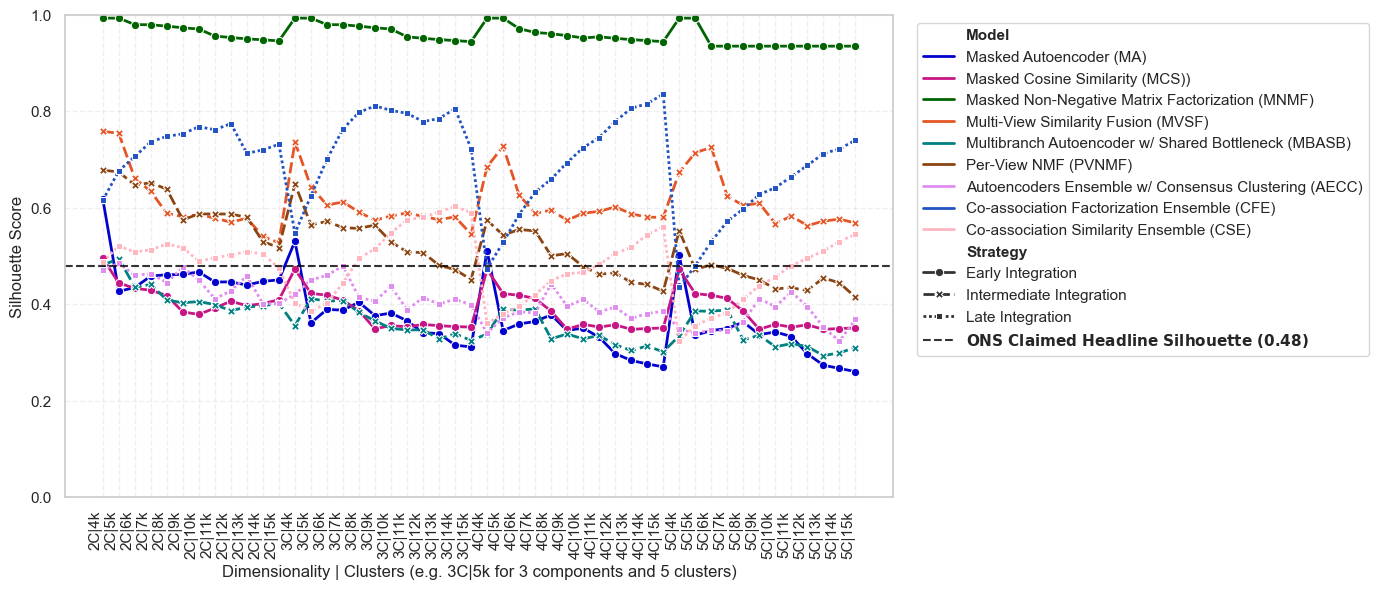

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort and create formatted x-axis labels
MVL_results_sorted = MVL_results.sort_values(
    by=['n_components', 'k'], ascending=[True, True]
).copy()

MVL_results_sorted["Dim|Clusters"] = (
    MVL_results_sorted["n_components"].astype(str) + "C|" +
    MVL_results_sorted["k"].astype(str) + "k"
)

# Set up plot styling
custom_hex_palette = [
    "#0202CD", "#C71585", "#006400", "#E55526", "#008080", "#8B4513", "#E08DF0",
    "#2253C3", "#FFB6C1", "#5DCAFA", "#708090", "#FFFF00", "#1D0E2A", "#AFF9A2", "#4B0082"
]

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid", rc={"grid.linestyle": "--", "grid.alpha": 0.3})

sns.lineplot(
    data=MVL_results_sorted,
    x="Dim|Clusters",
    y="Silhouette",
    hue="Model",
    style="Strategy",
    markers=True,
    dashes=True,
    palette=custom_hex_palette,
    linewidth=2
)

# Add horizontal line at ONS silhouette score
plt.axhline(
    y=0.48, color="black", linestyle="--", linewidth=1.5, alpha=0.8,
    label=r"$\bf{ONS\ Claimed\ Headline\ Silhouette\ (0.48)}$"
)

# Axis labels
plt.xlabel("Dimensionality | Clusters (e.g. 3C|5k for 3 components and 5 clusters)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.xticks(rotation=90, ha='right')

# Legend formatting
legend = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True)
legend.set_title(None)  # Remove legend title

# Bold only the subtitles (Model, Strategy) not the labels underneath
for text in legend.get_texts():
    if text.get_text() in ["Model", "Strategy"]:
        text.set_fontweight("bold")

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0, 1)

plt.savefig(
    r".\Pictures\MVL_Experiment_Results_SPATIAL.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)

plt.show()

### MVSF - Evaluation and Diagnostics

#### Cluster Summaries

In [17]:
from EDA_plots import compute_cluster_feature_stats

top_zscore_features, top_kl_features, top_las_by_cluster = compute_cluster_feature_stats(
    views=views,
    labels=MVSF_labels,
    area_codes=area_codes,
    top_k=10,
)

print("Top Features by Max Absolute Z-Score:")
print(top_zscore_features)

print("\nTop Features by Mean KL Divergence:")
print(top_kl_features)

print("\nTop Local Authorities by Cluster:")
print(top_las_by_cluster)

Top Features by Max Absolute Z-Score:
                                             Feature  Max |Z-Score|  \
0  skills: Apprenticeships achieved by adults age...       1.499340   
1  connectivity: Percentage of premises with giga...       1.492133   
2  skills: Apprenticeships started by adults aged...       1.480106   
3  connectivity: Percentage of 4G coverage by at ...       1.476063   
4              economic: Gross median weekly pay (£)       1.473334   
5  skills: Proportion of the population aged 16-6...       1.472114   
6  educational_attainment: Percentage of persiste...       1.465354   
7  health: Proportion of adults (18+) overweight ...       1.454874   
8  wellbeing: Mean feeling things done in life ar...       1.427849   
9  health: Proportion of children overweight or o...       1.411851   

   Cluster (at max)  
0               2.0  
1               0.0  
2               2.0  
3               0.0  
4               2.0  
5               2.0  
6               2.0  
7   

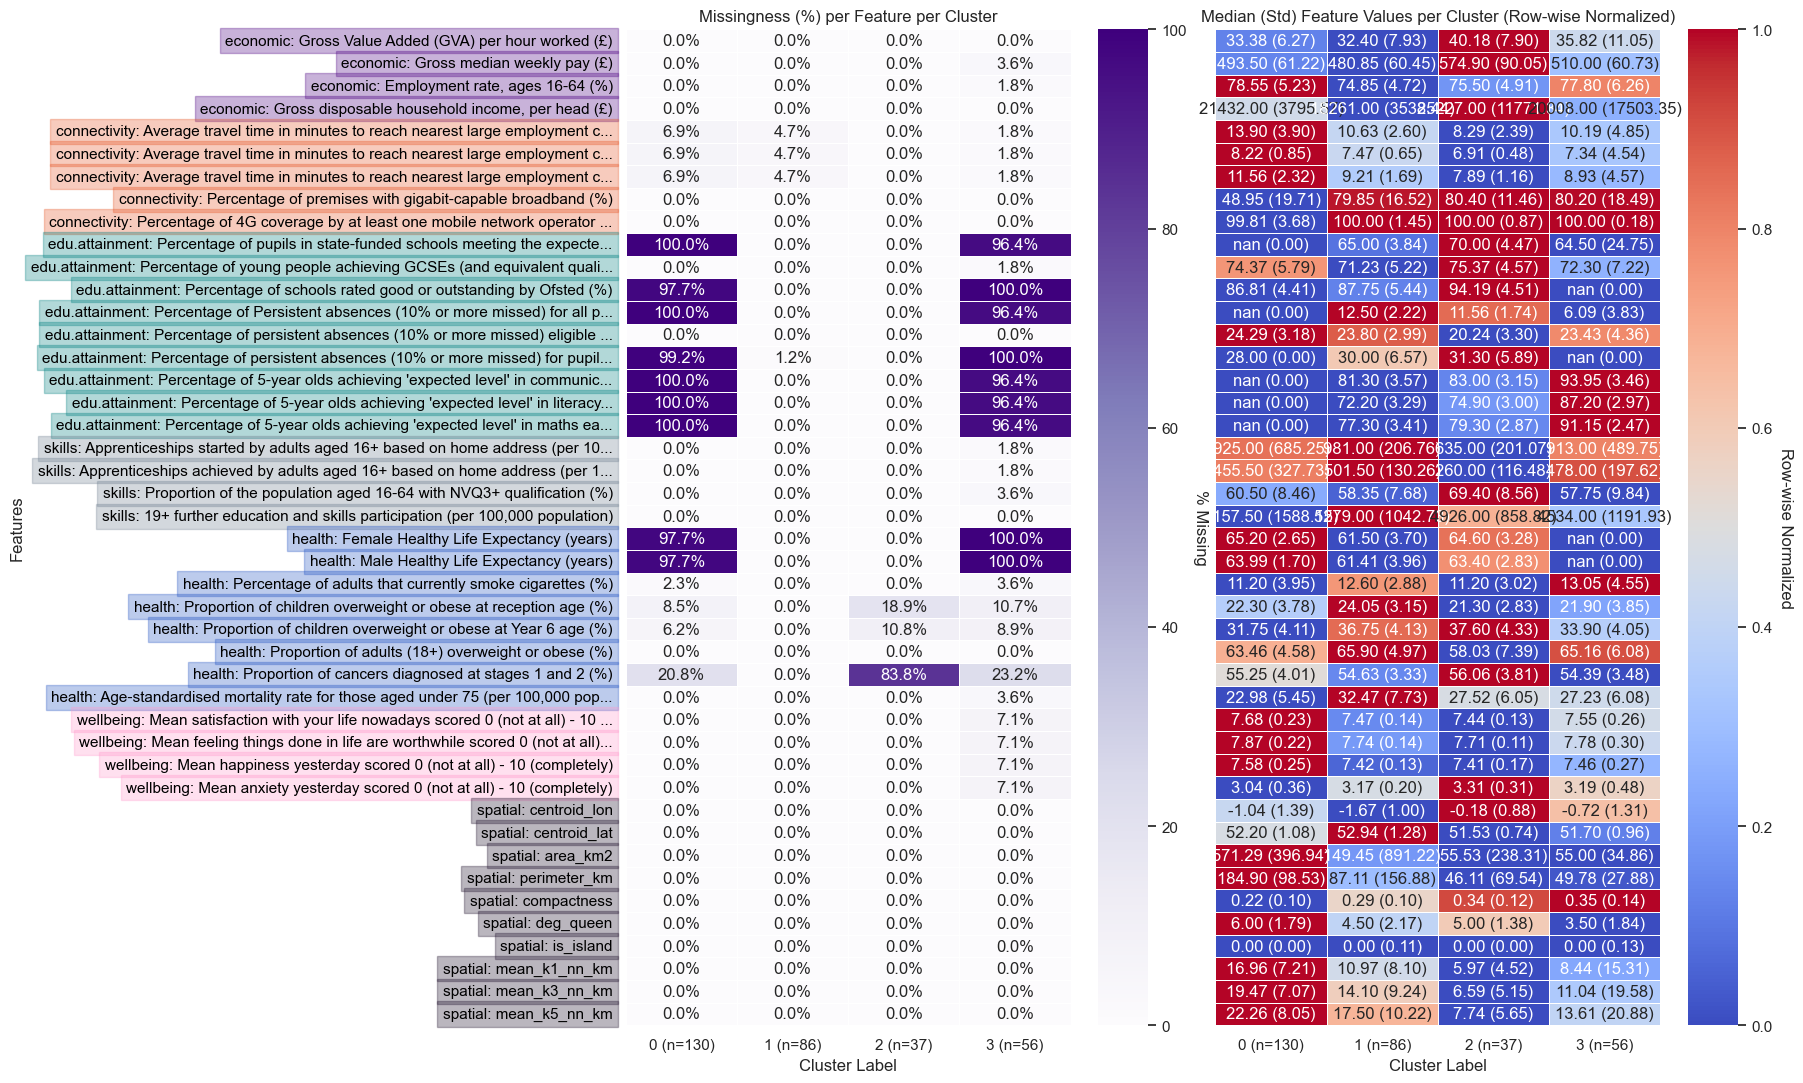

(Cluster                                                      0         1  \
 economic: Gross Value Added (GVA) per hour work...    0.000000  0.000000   
 economic: Gross median weekly pay (£)                 0.000000  0.000000   
 economic: Employment rate, ages 16-64 (%)             0.000000  0.000000   
 economic: Gross disposable household income, pe...    0.000000  0.000000   
 connectivity: Average travel time in minutes to...    6.923077  4.651163   
 connectivity: Average travel time in minutes to...    6.923077  4.651163   
 connectivity: Average travel time in minutes to...    6.923077  4.651163   
 connectivity: Percentage of premises with gigab...    0.000000  0.000000   
 connectivity: Percentage of 4G coverage by at l...    0.000000  0.000000   
 edu.attainment: Percentage of pupils in state-f...  100.000000  0.000000   
 edu.attainment: Percentage of young people achi...    0.000000  0.000000   
 edu.attainment: Percentage of schools rated goo...   97.692308  0.000000   

In [18]:
from EDA_plots import plot_missingness_and_means
from data_preprocessing import DEFAULT_META_COLS as META_COLS

# Apply
views_custom_hex_palette = [
    "#4B0082", "#E55526", "#008080",
    "#708090", "#2253C3", "#FF99CC", "#1D0E2A", "#AFF9A2", "#FFFF00",
]

plot_missingness_and_means(
    views, 
    MVSF_labels, 
    area_codes, 
    META_COLS, 
    views_custom_hex_palette,
    savepath=r".\Pictures\MVSF_Clusters_Summaries_SPATIAL.png", dpi=600)


#### Comparison vs. Canonical profiles

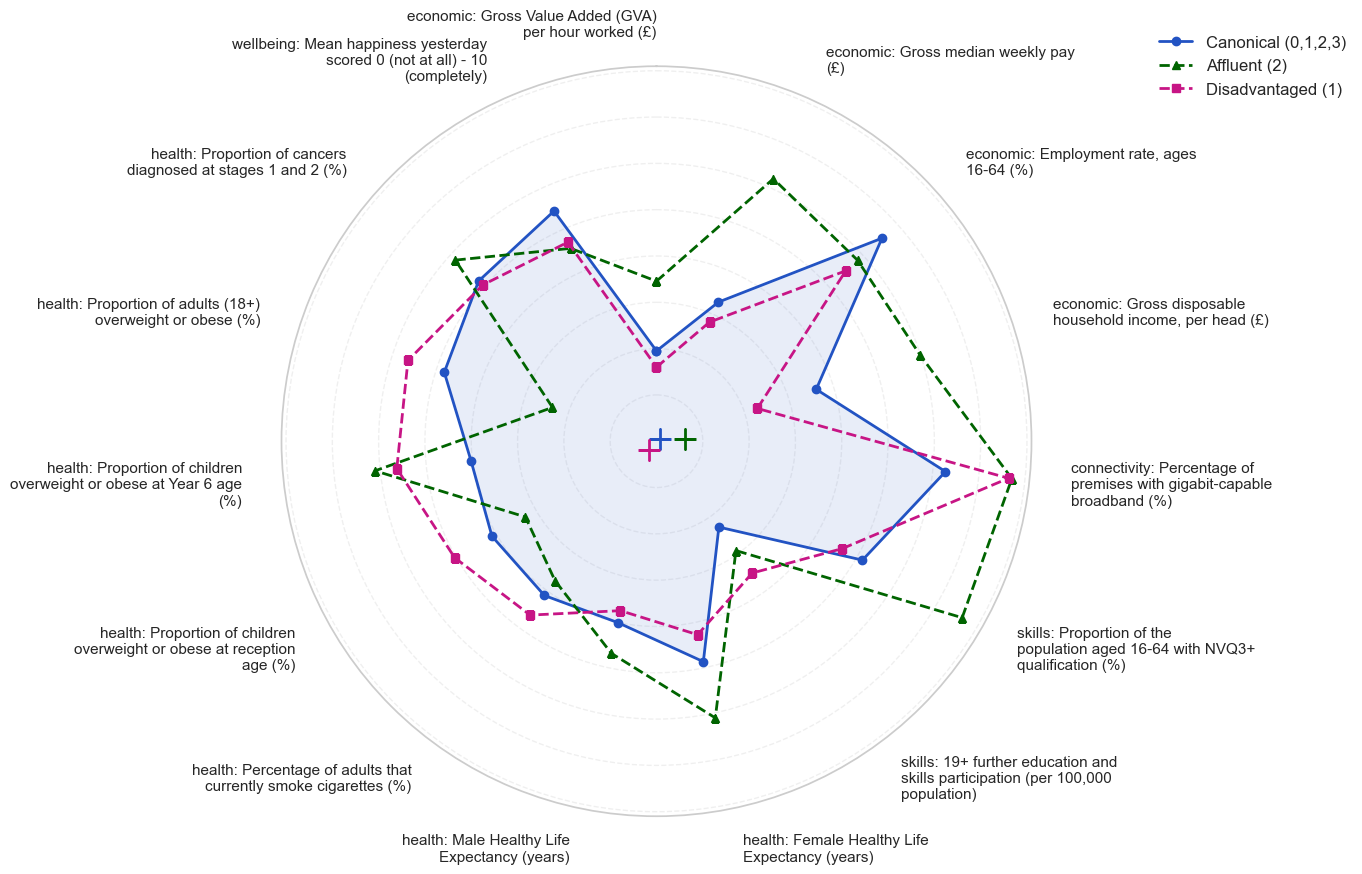

In [34]:
from EDA_plots import canonical_feature_signs, custom_hex_palette, radar_plot_clusters_on_canonical_features

profiles_grouped = radar_plot_clusters_on_canonical_features(
    views=views,
    labels=MVSF_labels,
    area_codes=area_codes,
    canonical_feature_signs=canonical_feature_signs,
    color_palette=custom_hex_palette,

    # legacy args
    exclude_clusters=None,
    combine_groups=None,

    # controls
    direction_align=False,
    strict_complete_cases=False,
    normalization_scope="complete_cases",

    # grouped subsets
    canonical_clusters=None,     # include ALL clusters automatically
    affluent_clusters=[2],
    disadvantaged_clusters=[1],
    canonical_use_all=True,
)

#### Silhouette Report

[ablation] similarity-based (k=4, n_pca=2), baseline=0.7587


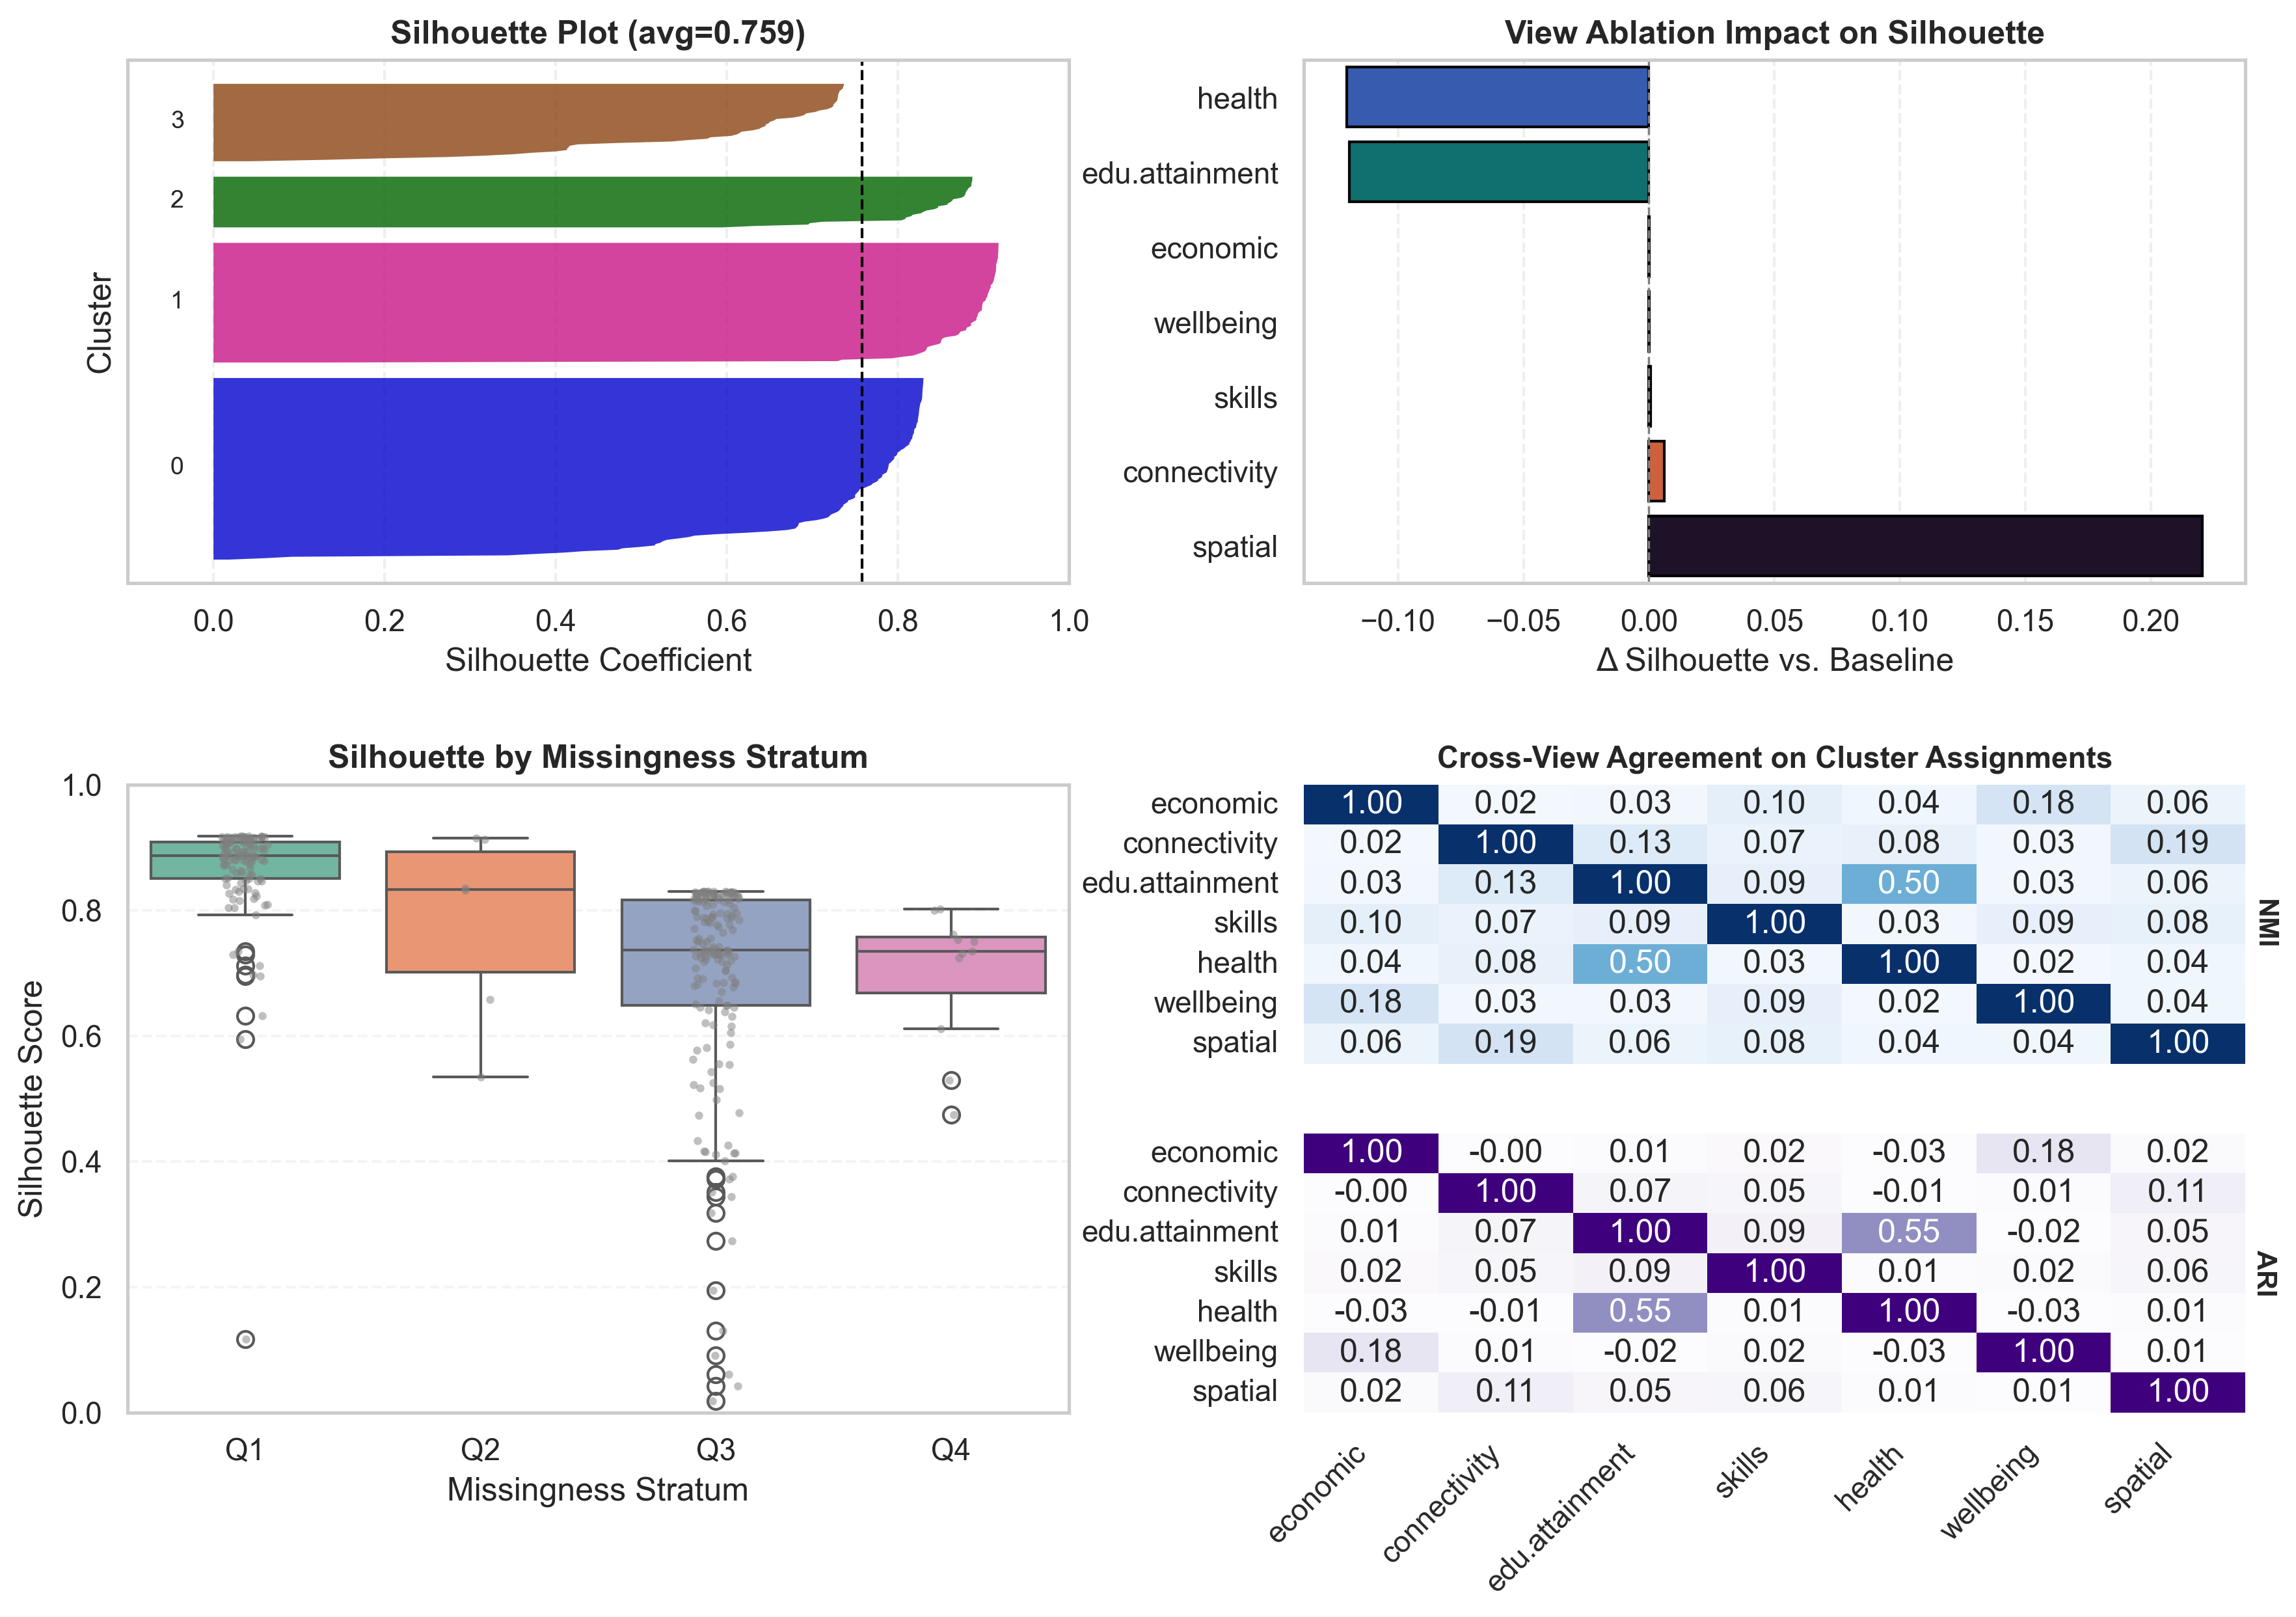

In [33]:
from diagnostics_reports import ablation_importance_from_out, plot_silhouette_report
from similarity_based_methods import multiview_similarity_fusion, cluster_from_similarity

# Palettes
views_custom_hex_palette = [
    "#4B0082", "#E55526", "#008080",
    "#708090", "#2253C3", "#FF99CC", "#1D0E2A", "#AFF9A2", "#FFFF00",
]
clusters_custom_hex_palette = [
    "#0202CD", "#C71585", "#006400", "#8B4513",
    "#1D0E2A", "#4B0082", "#E55526", "#008080",
    "#708090", "#2253C3", "#FF99CC", "#AFF9A2",
]

# Compute view ablation
ablation_df_view = ablation_importance_from_out(
    method_out=MVSF_out,
    views=views,
    k=4,
    n_pca=2,
    multiview_similarity_fusion=multiview_similarity_fusion,
    cluster_from_similarity=cluster_from_similarity,
    mode="view"
)

# Build dict of similarity matrices
view_names = list(views.keys())
similarity_matrices_dict = {vn: S for vn, S in zip(view_names, MVSF_similarity_matrices)}

# Plot Silhouette Report for MVSF
fig, sil_df = plot_silhouette_report(
    embedding=MVSF_embedding,
    labels=MVSF_labels,
    views_dict=views,
    area_codes=area_codes,
    ablation_df_view=ablation_df_view,
    similarity_matrices=similarity_matrices_dict,
    view_names=view_names,
    views_palette=views_custom_hex_palette,
    clusters_palette=clusters_custom_hex_palette,
    strat_method="quantiles",
    figsize=(14, 9),
    box_ylim=(0.0, 1.0),
    dpi=300,
)

# Save to file
fig.savefig(".\Pictures\MVSF_silhouette_report_SPATIAL.png", dpi=300, bbox_inches="tight")

Silhouette score: 0.758736386625859
Calinski-Harabasz score: 5311.878518935109
Davies-Bouldin_score: 0.32074246503392295


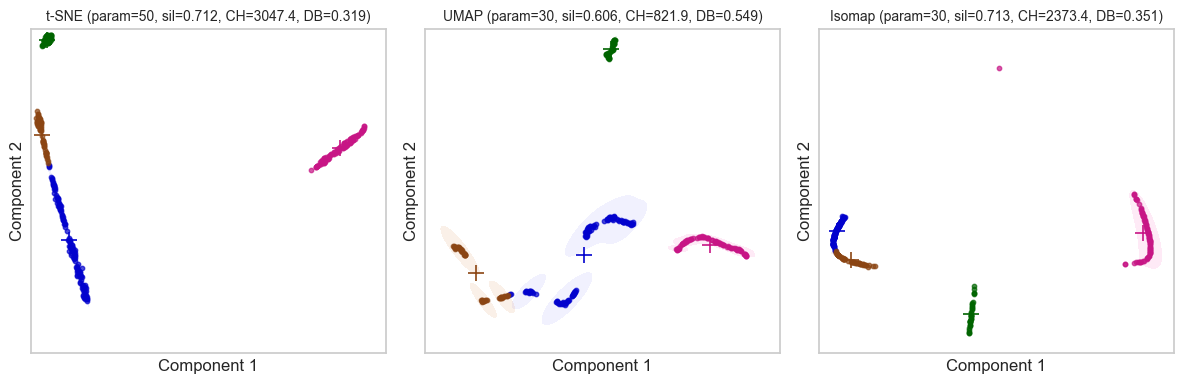

{'t-SNE': {'embedding': array([[ 2.45794544e+01,  2.15299892e+00],
         [ 2.53826447e+01,  2.84143424e+00],
         [ 2.21825047e+01,  8.40355933e-01],
         [ 2.28686523e+01,  1.11838782e+00],
         [ 2.28504333e+01,  1.03413463e+00],
         [ 2.45796986e+01,  2.45849490e+00],
         [ 2.30204582e+01,  1.14297044e+00],
         [ 2.30224209e+01,  1.44189024e+00],
         [ 2.56516457e+01,  3.20720148e+00],
         [ 2.51055222e+01,  2.63176155e+00],
         [ 2.08621483e+01, -2.11065337e-01],
         [ 2.29256477e+01,  1.11009359e+00],
         [ 2.10532055e+01, -6.31504729e-02],
         [ 2.18887100e+01,  6.65627956e-01],
         [ 2.47465858e+01,  2.23874998e+00],
         [-8.69811440e+00,  1.12048988e+01],
         [ 2.00072098e+01, -6.54559910e-01],
         [ 2.48202934e+01,  2.51389003e+00],
         [ 2.05735989e+01, -2.25511014e-01],
         [ 2.18842411e+01,  6.65072381e-01],
         [ 2.42397537e+01,  2.26007915e+00],
         [-9.22767162e+00,  1.101

In [22]:
from plots_and_visualisations import plot_best_embedding
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Cluster validation
print("Silhouette score:",silhouette_score(MVSF_embedding, MVSF_labels))
print("Calinski-Harabasz score:",calinski_harabasz_score(MVSF_embedding, MVSF_labels))
print("Davies-Bouldin_score:", davies_bouldin_score(MVSF_embedding, MVSF_labels))

# Embedding plot
plot_best_embedding(MVSF_embedding, MVSF_labels)

#### Fusion Report

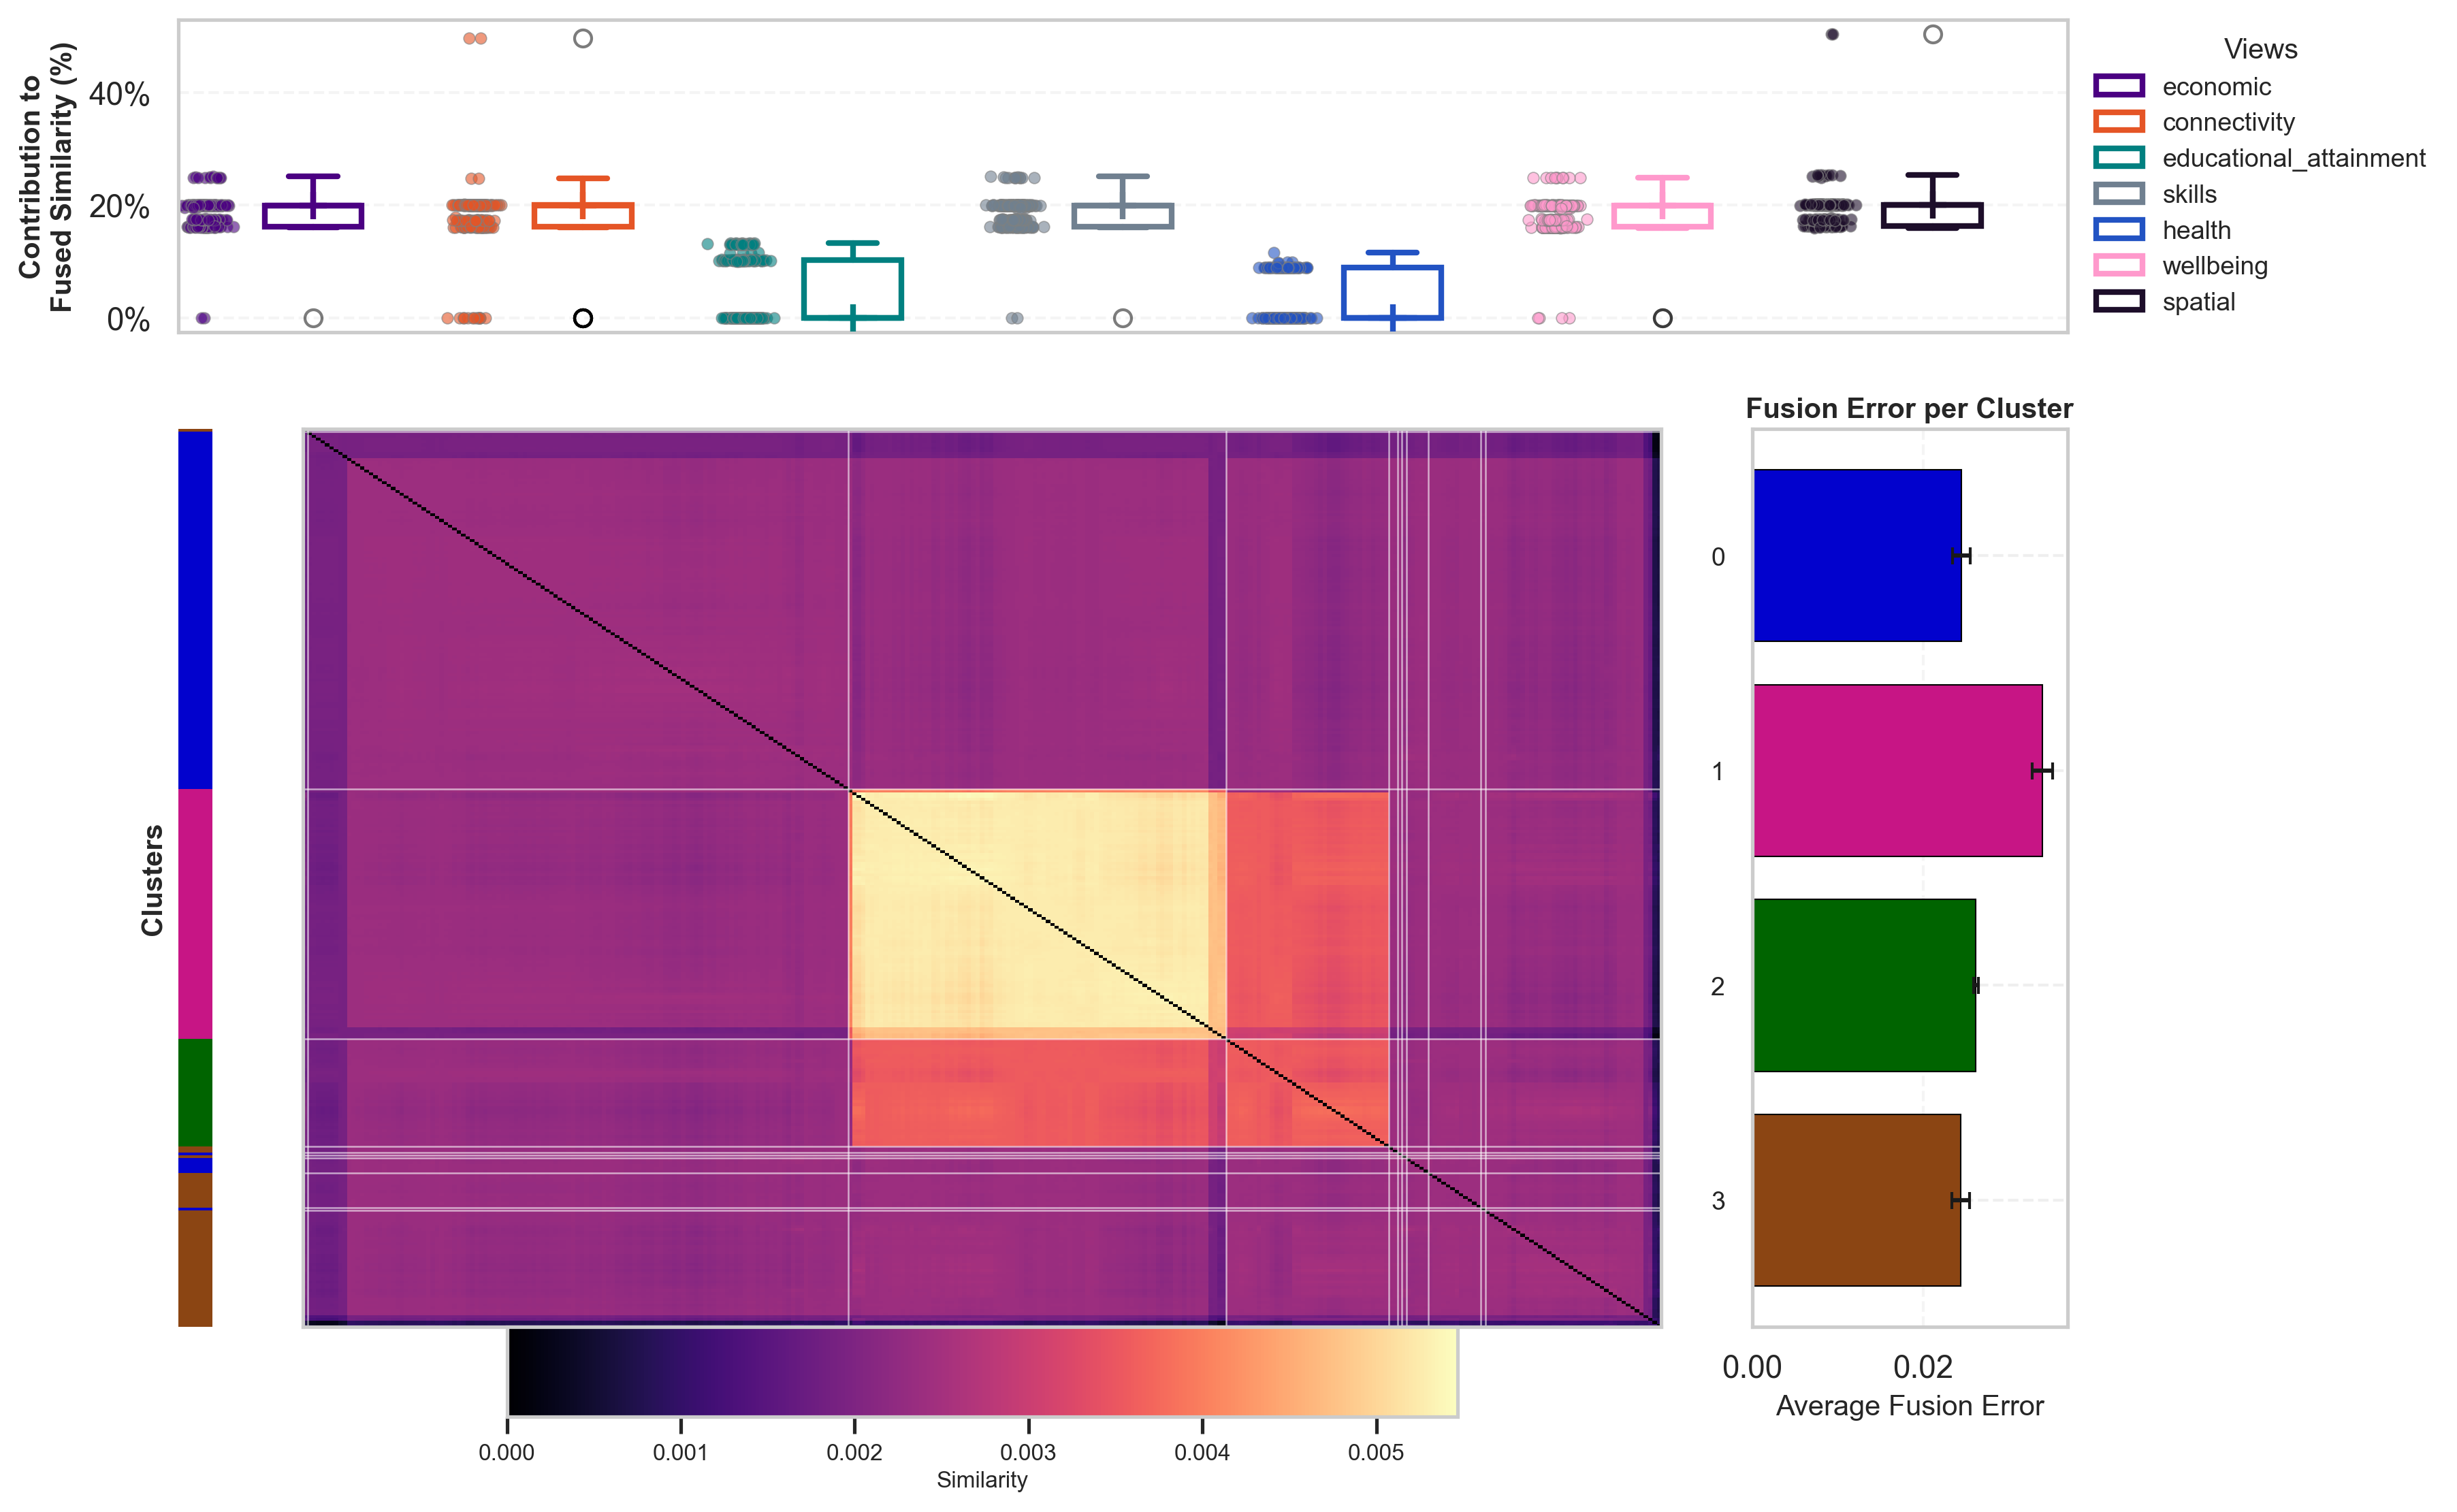

In [23]:
from diagnostics_reports import plot_fusion_report

fusion_report = plot_fusion_report(
    method_out=MVSF_out,
    views_custom_hex_palette=[
        "#4B0082", "#E55526", "#008080",
        "#708090", "#2253C3", "#FF99CC", "#1D0E2A", "#AFF9A2", "#FFFF00"
    ],
    clusters_custom_hex_palette=[
        "#0202CD", "#C71585", "#006400", "#8B4513", "#1D0E2A", "#4B0082",
        "#E55526", "#008080", "#708090", "#2253C3", "#FF99CC", "#1D0E2A", "#AFF9A2"
    ],
    linkage_method="average",
    figsize=(10, 8),
    dpi=300,
    heatmap_cmap="magma",
    savepath=r".\Pictures\MVSF_Fusion_Report_SPATIAL.png"
)

### CFE - Evaluation and Diagnostics

#### Cluster Summaries

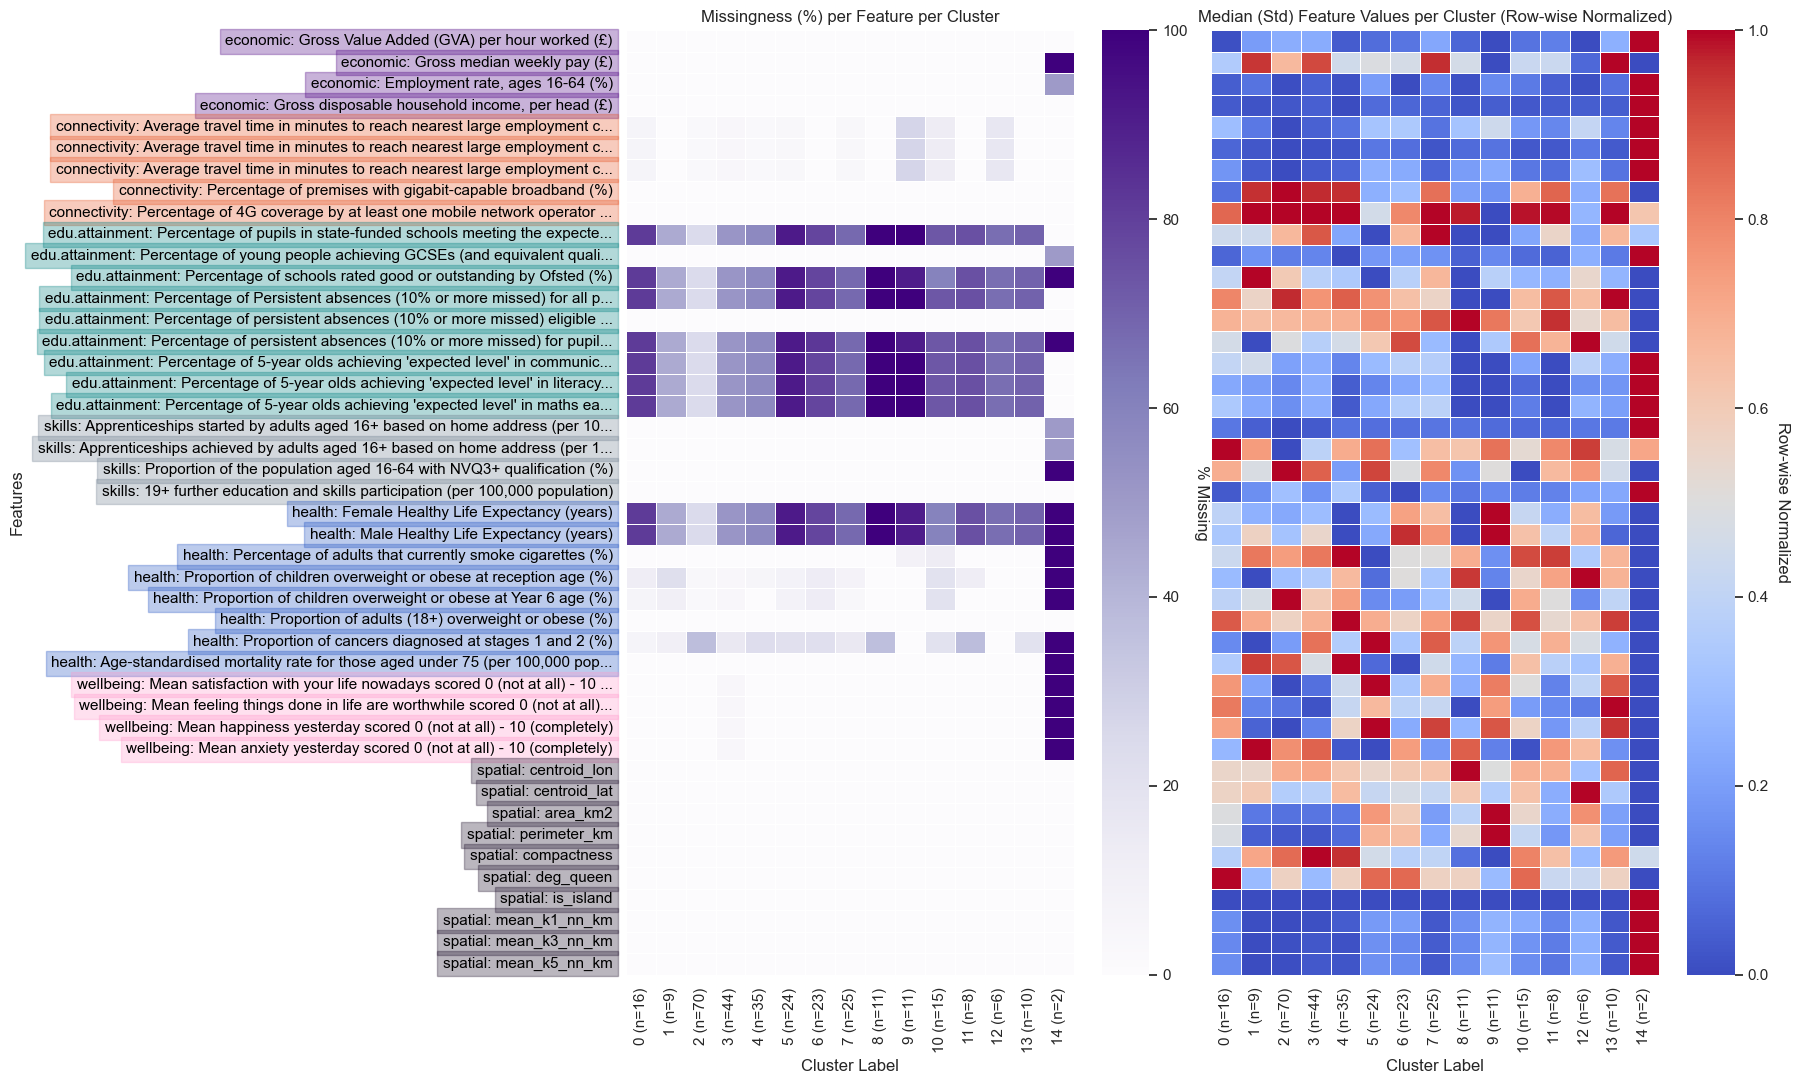

(Cluster                                                 0          1  \
 economic: Gross Value Added (GVA) per hour work...   0.00   0.000000   
 economic: Gross median weekly pay (£)                0.00   0.000000   
 economic: Employment rate, ages 16-64 (%)            0.00   0.000000   
 economic: Gross disposable household income, pe...   0.00   0.000000   
 connectivity: Average travel time in minutes to...   6.25   0.000000   
 connectivity: Average travel time in minutes to...   6.25   0.000000   
 connectivity: Average travel time in minutes to...   6.25   0.000000   
 connectivity: Percentage of premises with gigab...   0.00   0.000000   
 connectivity: Percentage of 4G coverage by at l...   0.00   0.000000   
 edu.attainment: Percentage of pupils in state-f...  81.25  44.444444   
 edu.attainment: Percentage of young people achi...   0.00   0.000000   
 edu.attainment: Percentage of schools rated goo...  81.25  44.444444   
 edu.attainment: Percentage of Persistent absenc...

In [24]:
from EDA_plots import plot_missingness_and_means
from data_preprocessing import DEFAULT_META_COLS as META_COLS

# Apply
views_custom_hex_palette = [
    "#4B0082", "#E55526", "#008080",
    "#708090", "#2253C3", "#FF99CC", "#1D0E2A", "#AFF9A2", "#FFFF00",
]

plot_missingness_and_means(
    views, 
    CFE_labels, 
    area_codes, 
    META_COLS, 
    views_custom_hex_palette,
    savepath=r".\Pictures\CFE_Clusters_Summaries_SPATIAL.png", dpi=600)


#### Comparison vs. Canonical Profiles

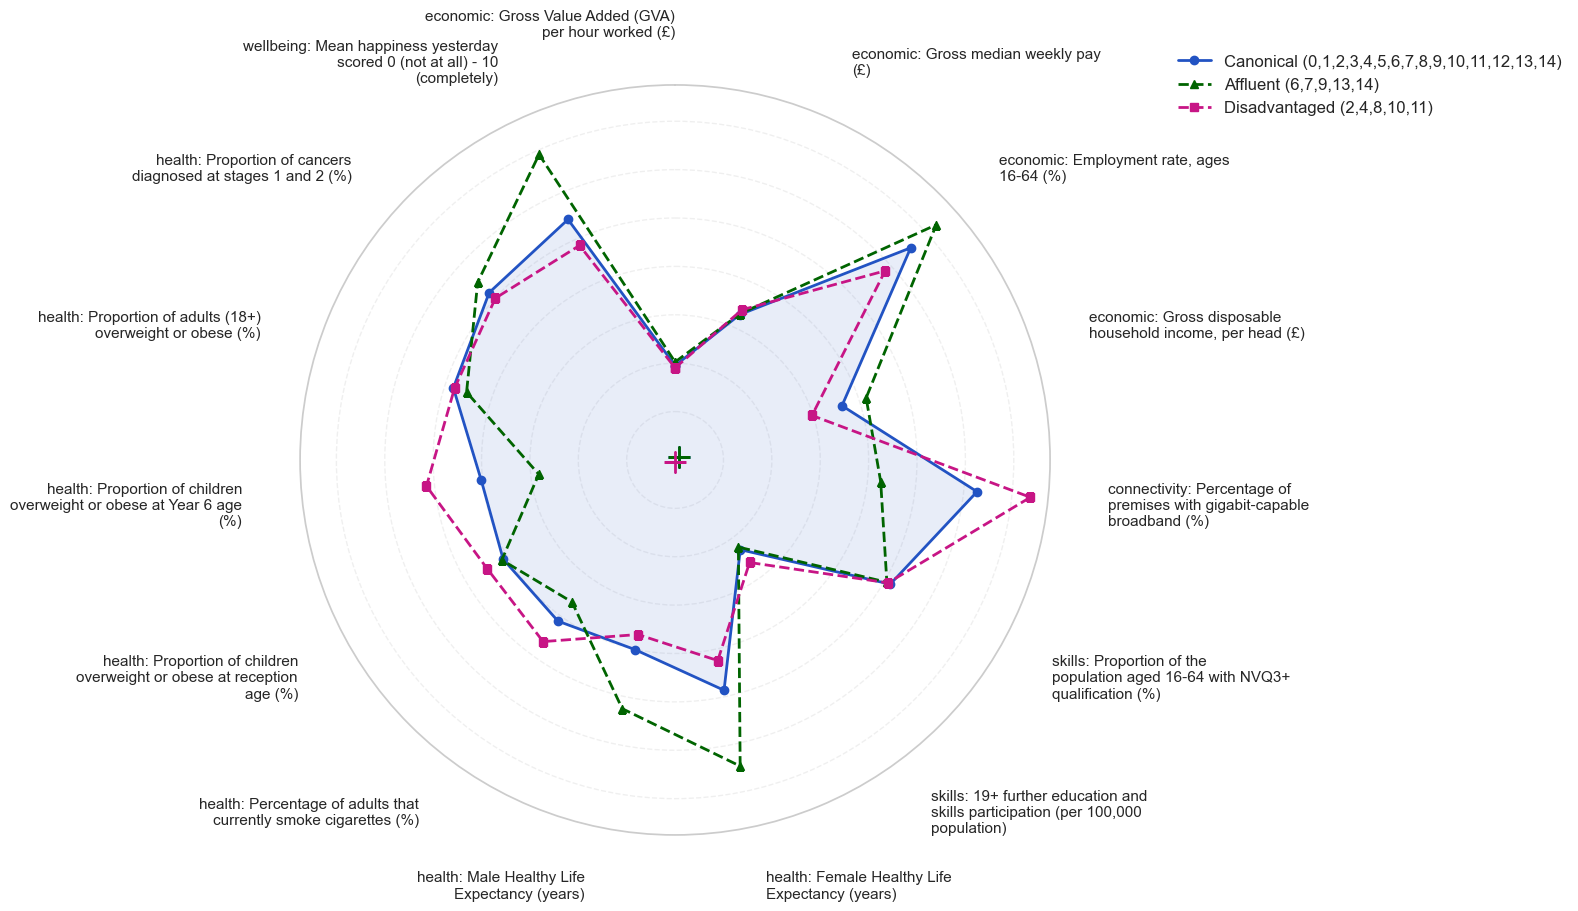

In [25]:
profiles_grouped = radar_plot_clusters_on_canonical_features(
    views=views,
    labels=CFE_labels,
    area_codes=area_codes,
    canonical_feature_signs=canonical_feature_signs,
    color_palette=custom_hex_palette,

    # keep legacy args
    exclude_clusters=None,
    combine_groups=None,

    # usual controls
    direction_align=False,
    strict_complete_cases=False,
    normalization_scope="complete_cases",

    # grouped subsets
    canonical_clusters=None,
    affluent_clusters=[6,7,9,13,14],
    disadvantaged_clusters=[2,4,8,10,11],
    canonical_use_all=True, 
)

#### Silhouette Report

In [26]:
def align_labels_per_view(clusterings, global_area_codes):
    """
    clusterings: dict like {"economic": {"area_codes": [...], "labels": [...]}, ...}
    global_area_codes: list/array of length N (=309) in the order you plot/report
    Returns: dict {view_name: np.ndarray (N,), values in {0.., -1 for missing}}
    """
    gidx = pd.Index(pd.Series(global_area_codes, dtype=str).str.strip())
    aligned = {}

    for vn, info in clusterings.items():
        v_codes = pd.Series(info["area_codes"], dtype=str).str.strip()
        v_labels = pd.Series(info["labels"], index=v_codes)

        # Reindex to global order; -1 for LAs missing in this view
        aligned[vn] = (
            v_labels.reindex(gidx, fill_value=-1)
                    .astype(int, errors="ignore")
                    .to_numpy()
        )

    return aligned

[ablation] LATE (rank=2, n_pca=4, k=15), baseline=0.8360
N: 309
                economic: shape=(309,), missing(-1)=2
            connectivity: shape=(309,), missing(-1)=14
  educational_attainment: shape=(309,), missing(-1)=187
                  skills: shape=(309,), missing(-1)=2
                  health: shape=(309,), missing(-1)=223
               wellbeing: shape=(309,), missing(-1)=4


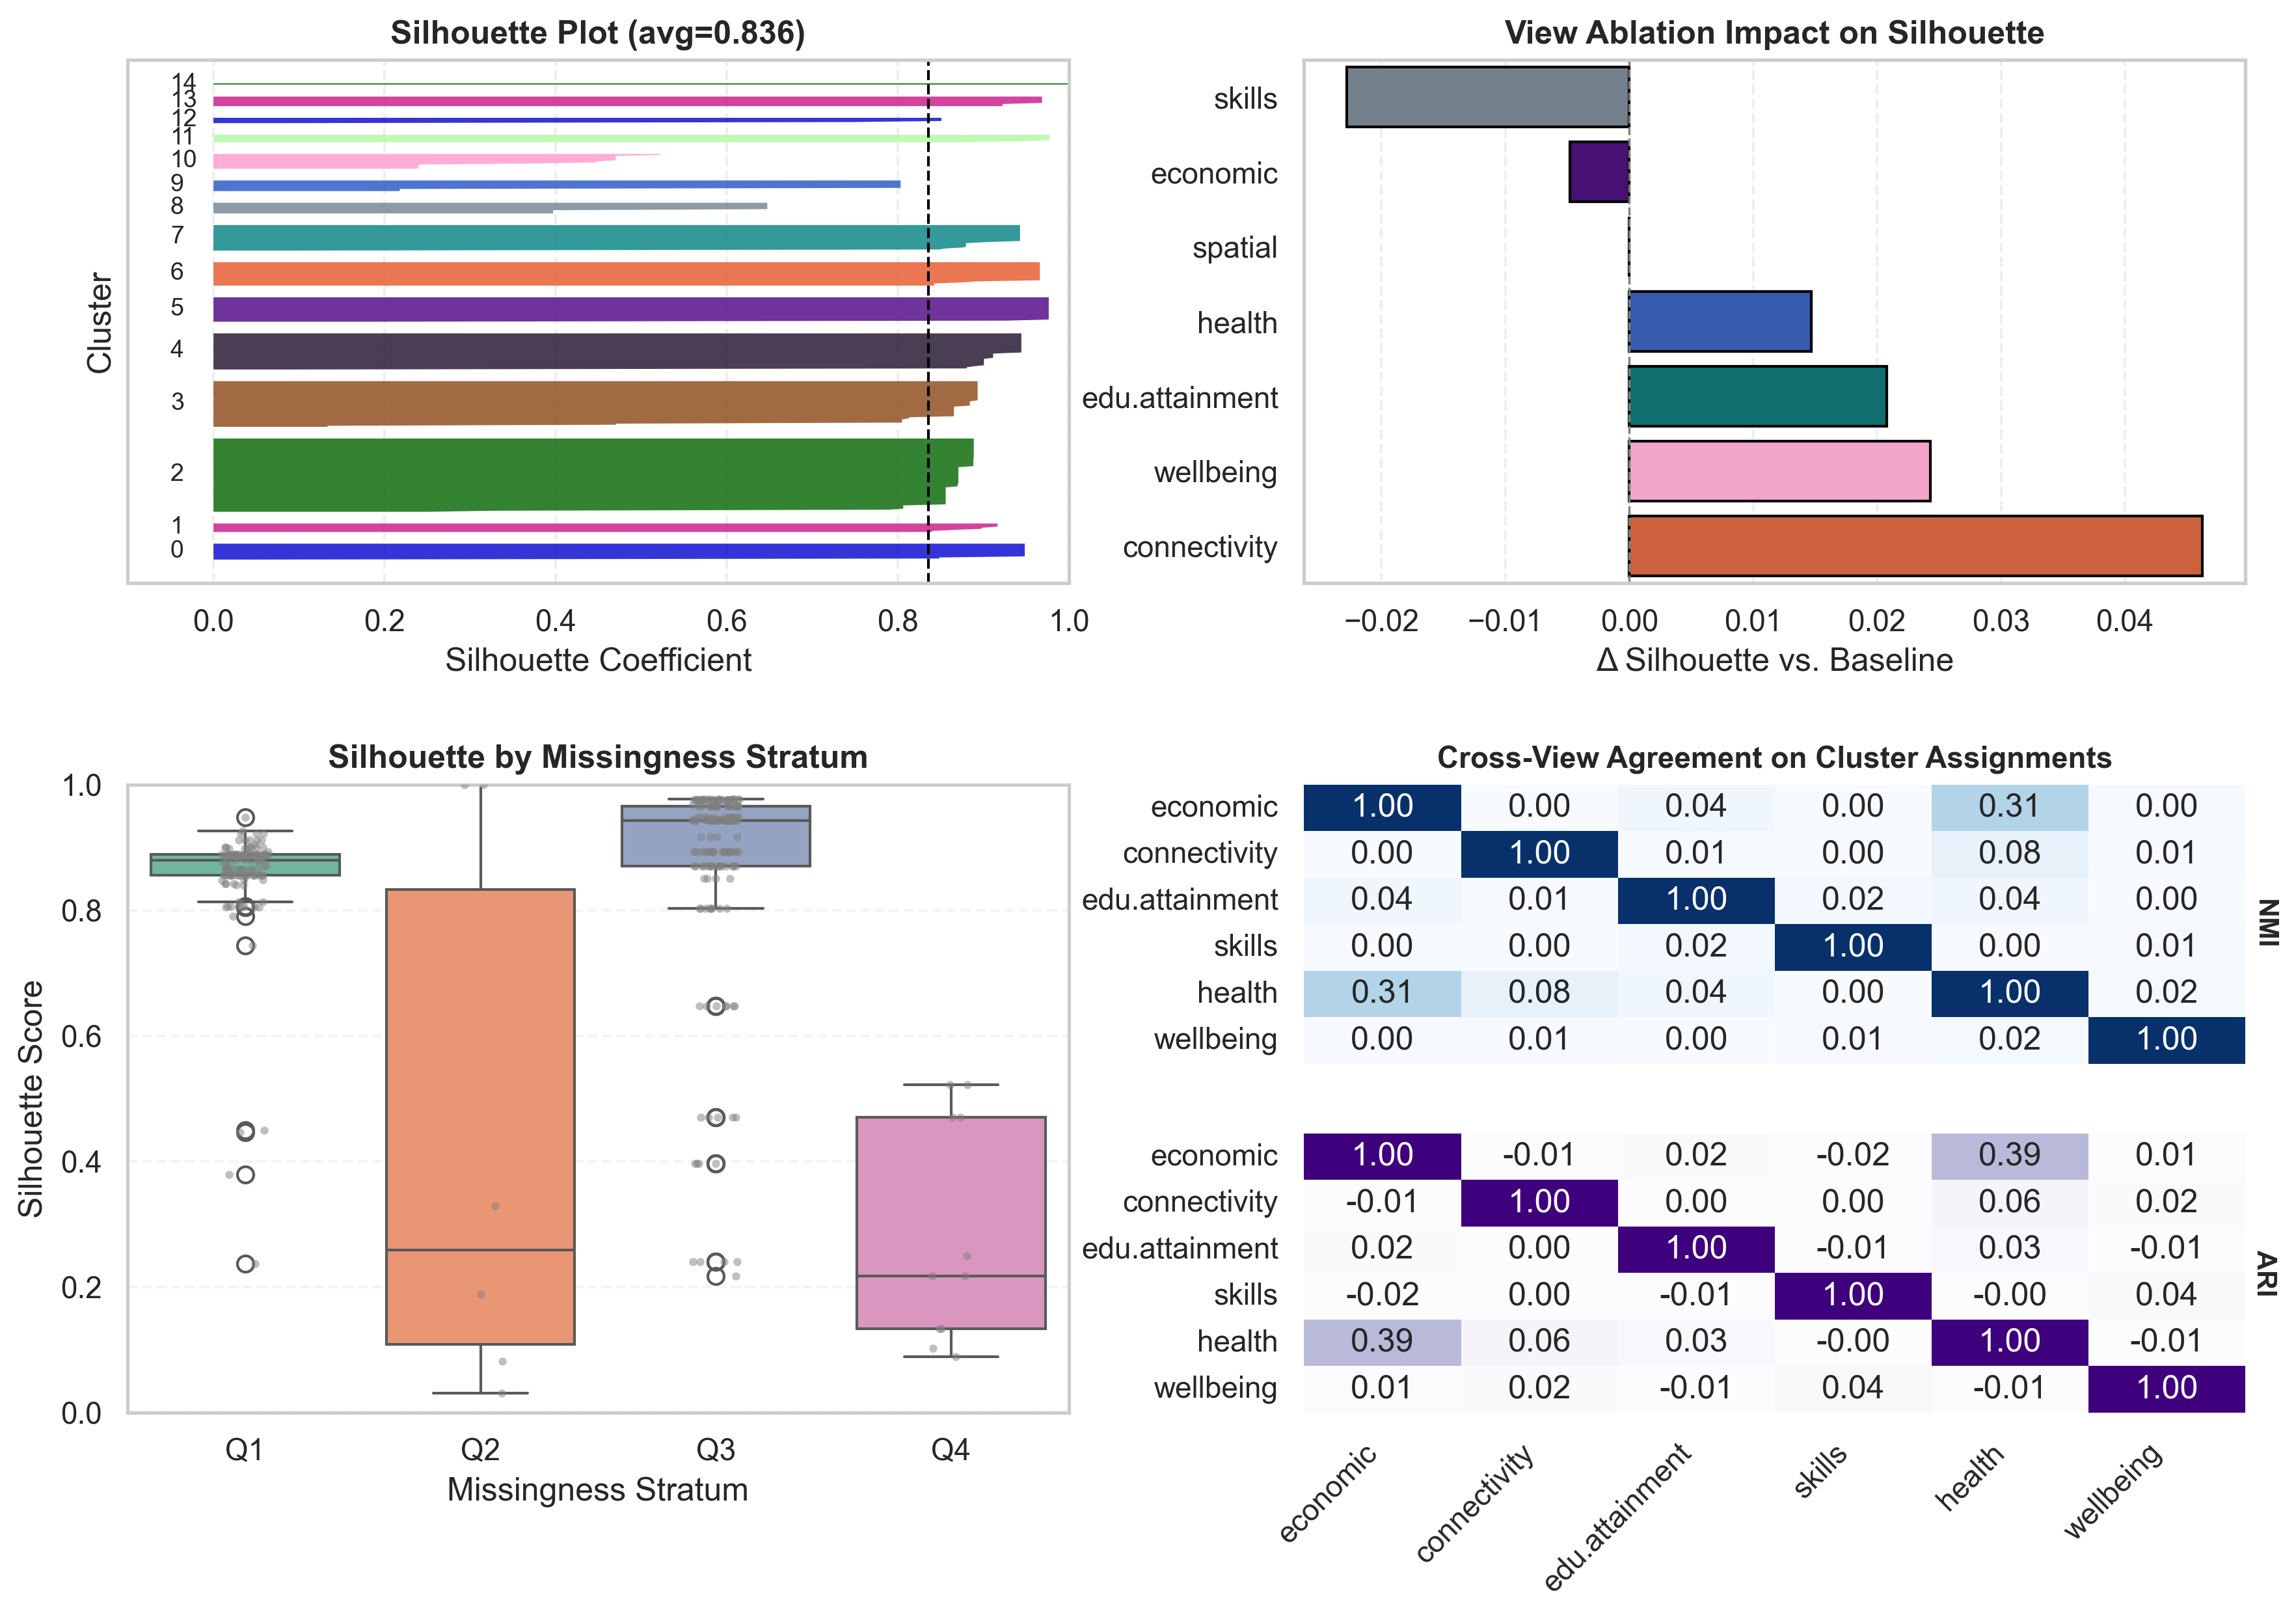

In [27]:
from diagnostics_reports import ablation_importance_from_out, plot_silhouette_report

# View ablation for late method
ablation_df_view = ablation_importance_from_out(
    method_out=CFE_out,
    views=views,
    run_late_fn=run_late_nmf_coassoc_pca_kmeans,  # late pipeline
    mode="view",
    verbose=True
)

# Palettes
views_palette = [
    "#4B0082", "#E55526", "#008080", "#708090", "#2253C3",
    "#FF99CC", "#1D0E2A", "#AFF9A2", "#FFFF00",
]
clusters_palette = [
    "#0202CD", "#C71585", "#006400", "#8B4513", "#1D0E2A",
    "#4B0082", "#E55526", "#008080", "#708090", "#2253C3",
    "#FF99CC", "#AFF9A2",
]

# Compute labels per view
# Align per-view labels to the master area_codes
labels_per_view_aligned = align_labels_per_view(CFE_out["clusterings"], area_codes)

print("N:", len(area_codes))
for vn, arr in labels_per_view_aligned.items():
    n_missing = int((arr == -1).sum())
    print(f"{vn:>24}: shape={arr.shape}, missing(-1)={n_missing}")

# Silhouette report
fig, sil_df = plot_silhouette_report(
    embedding=CFE_embedding,
    labels=CFE_labels,
    views_dict=views,
    area_codes=area_codes,
    ablation_df_view=ablation_df_view,
    similarity_matrices=None,
    labels_per_view=labels_per_view_aligned,
    view_names=list(views.keys()),
    views_palette=views_palette,
    clusters_palette=clusters_palette,
    strat_method="quantiles",
    box_ylim=(0.0, 1.0),
    figsize=(14, 9),
    dpi=300,
    nmi_ari_min_overlap=50,
    show_overlap_counts=False
)

# Save or show figure
fig.savefig(".\Pictures\CFE_silhouette_report_SPATIAL.png", dpi=300, bbox_inches="tight")

#### Factorization Report

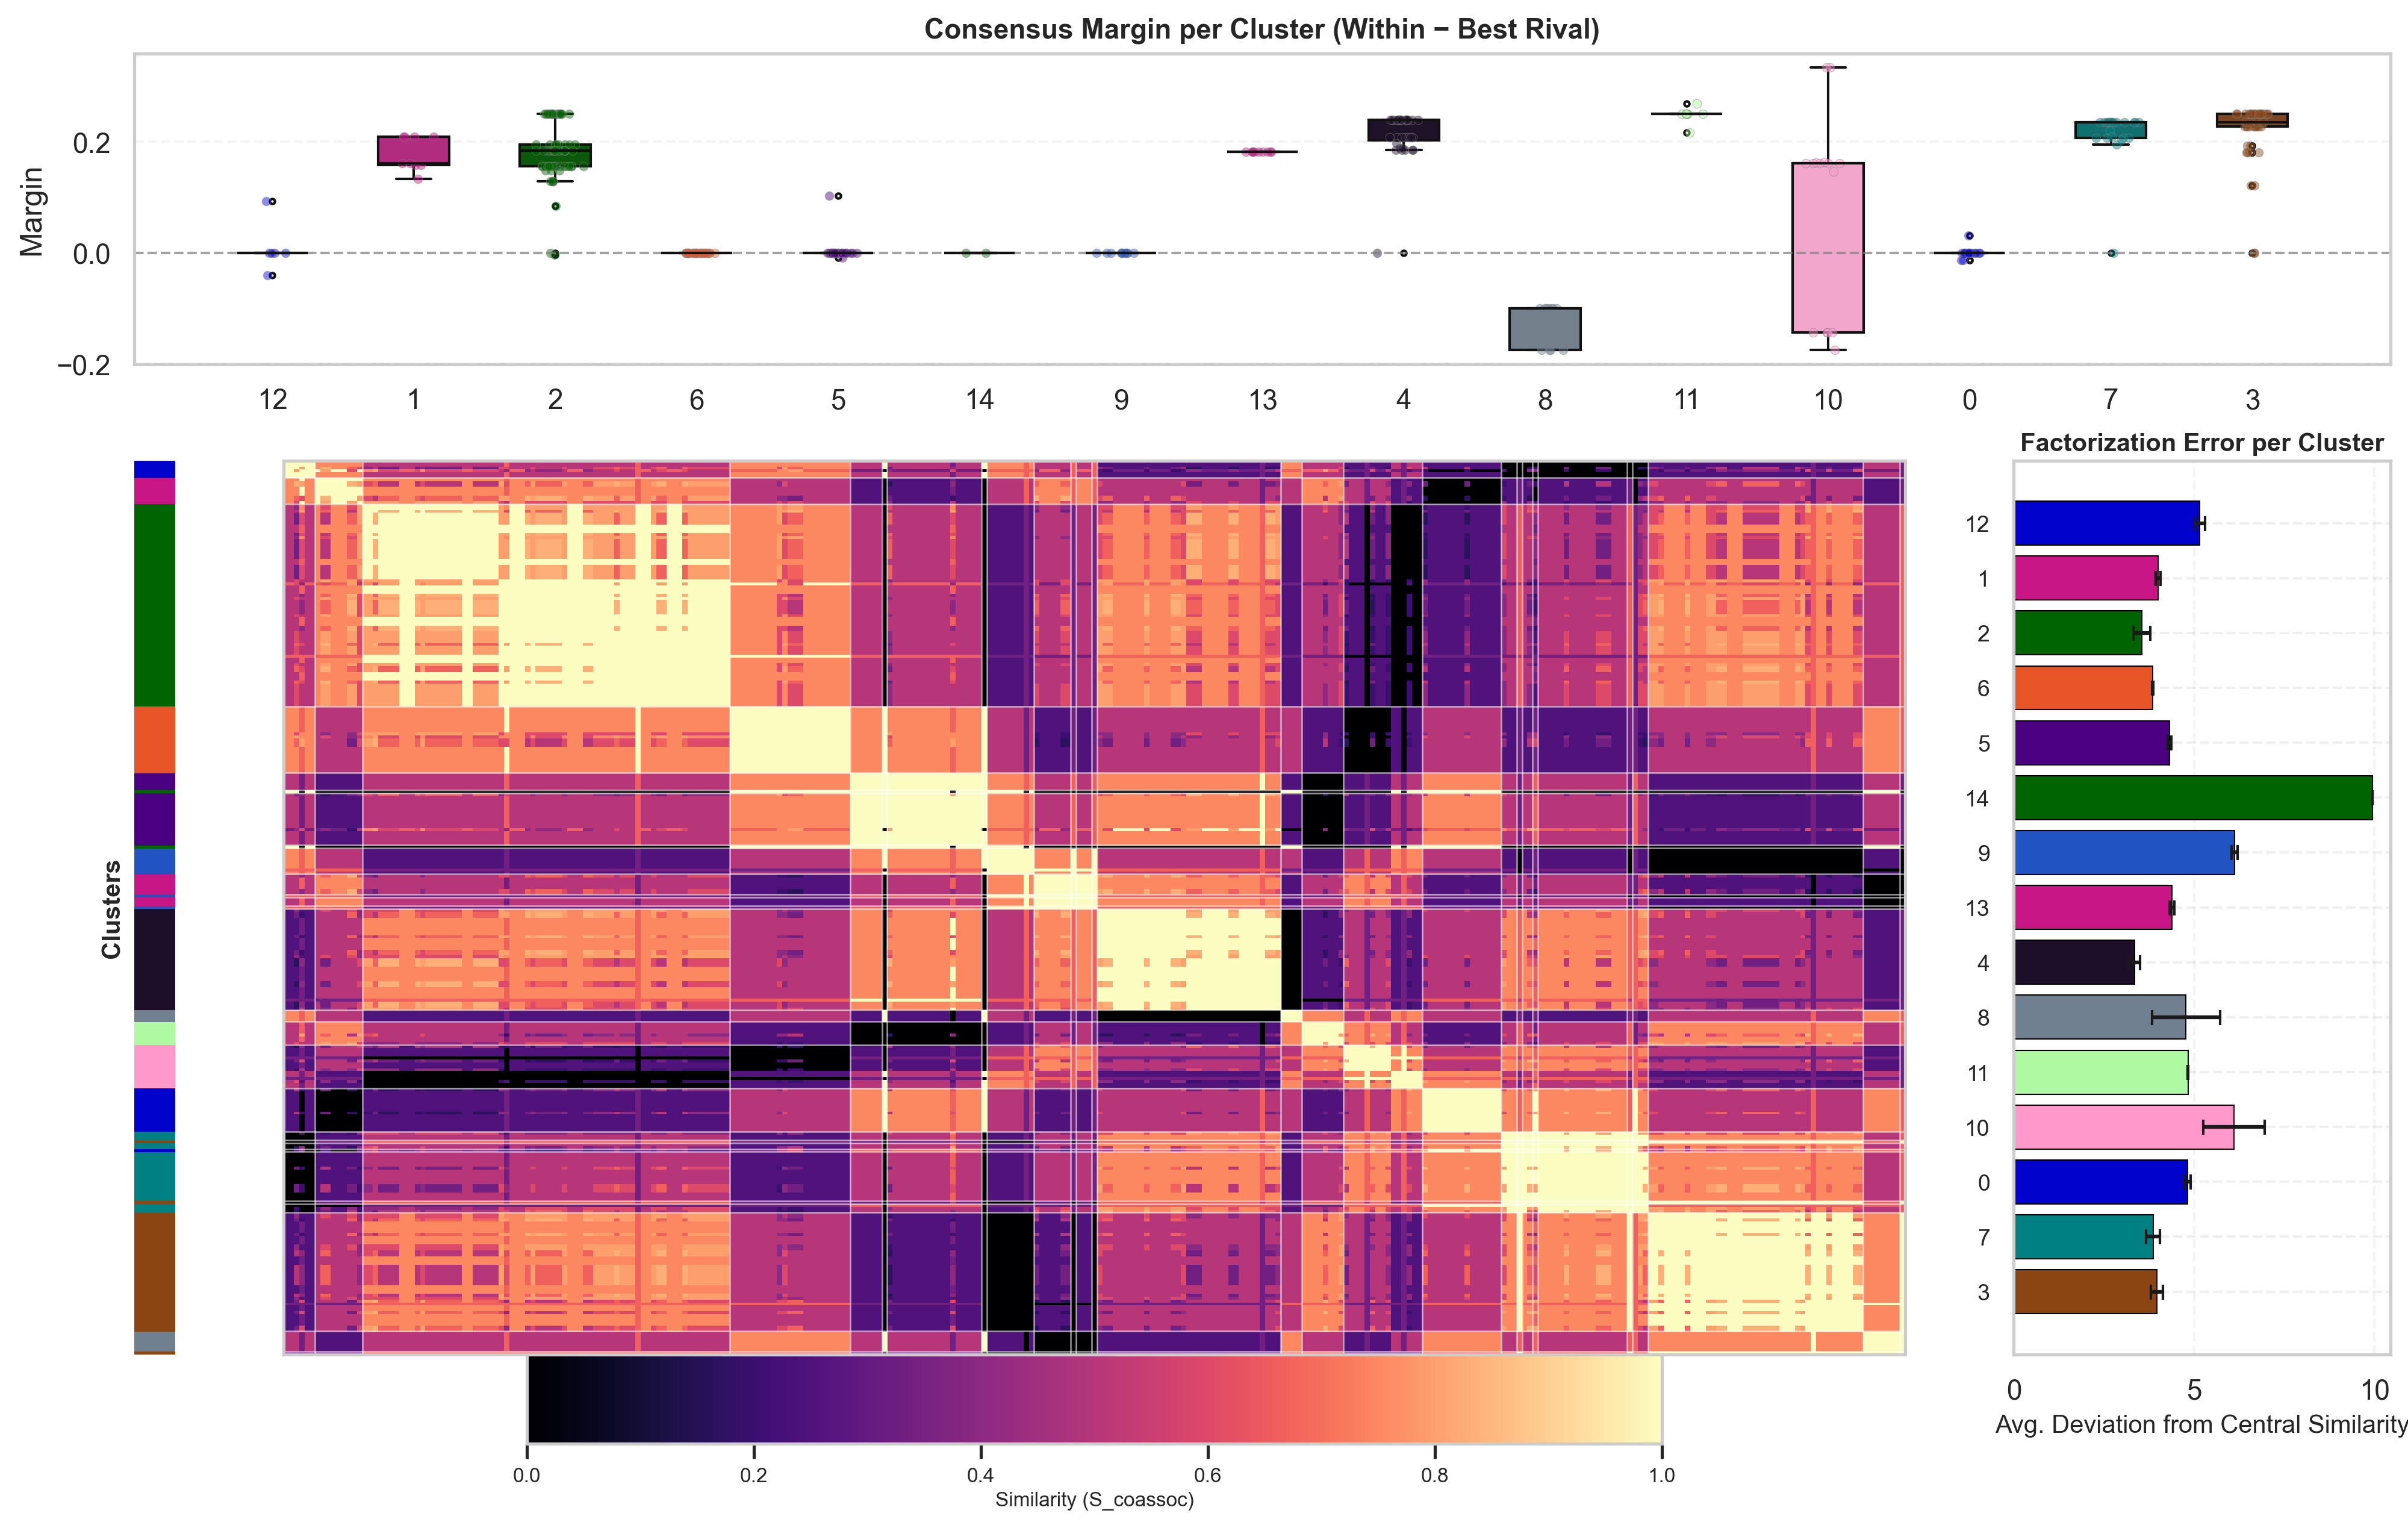

In [28]:
from diagnostics_reports import plot_factorization_report

CFE_report = plot_factorization_report(
    method_out=CFE_out,
    views_custom_hex_palette=views_palette,
    clusters_custom_hex_palette=clusters_palette,
    savepath=r".\Pictures\CFE_factorization_report_SPATIAL.png")